# 📌 간편지원 및 주제소개

##### 데이터 및 라이브러리 로드

In [ ]:
# 라이브러리 임포트

# 데이터 분석 기본
import pandas as pd
import numpy as np

# 시각화 라이브러리
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import seaborn as sns


# 분석용 라이브러리
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, log_loss
from scipy import stats

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 데이터 로드

application_data = pd.read_csv('Cleaned_Application.csv')
company_data = pd.read_csv('Cleaned_company_df.csv')
company_address_data = pd.read_csv('CompanyAddress.csv')
company_fund_data = pd.read_csv('Cleaned_Companyfund.csv')
job_data = pd.read_csv('Cleaned_Job.csv')
job_address_data = pd.read_csv('Cleaned_JobAddress.csv')
job_bookmark_data = pd.read_csv('Cleaned_JobBookmark.csv')
log_data = pd.read_csv('Cleaned_Logdata.csv')

##### 전처리

In [ ]:
# # 결측치 및 중복값 확인

# dataframes = [application_data, company_data, company_address_data, company_fund_data, job_data, job_address_data, job_bookmark_data, log_data_2022, log_data_2023]
# df_names = ['application_data', 'company_data', 'company_address_data', 'company_fund_data', 'job_data', 'job_address_data', 'job_bookmark_data', 'log_data_2022', 'log_data_2023']

# for df, name in zip(dataframes, df_names):
#     print(f"{name}의 결측치 :\n{df.isna().sum()}\n")
#     print(f"{name}의 결측치 비율 : \n{df.isna().sum() / len(df) * 100} \n")
#     print(f"{name}의 중복값 : {df.duplicated().sum()}\n")

In [ ]:
# # 중복값은 전체에 모두 없고, 결측치가 많고 분석에 실제로 사용하지 않을 job, company 제외 / 유효한 정보는 모두 있는 company_address, company_fund, job_address 제외
# dataframes_for_drop = [application_data, job_bookmark_data, log_data_2022, log_data_2023]
# df_names_for_drop = ['application_data', 'job_bookmark_data', 'log_data_2022', 'log_data_2023']


# for df,df_names in zip(dataframes_for_drop, df_names_for_drop):
#     df.drop_duplicates(inplace=True)
#     df.dropna(inplace=True)

In [ ]:
# # 이상치 확인, 이상치를 통해 제거할 칼럼 없음으로 판단단

# import pandas as pd
# import numpy as np

# dataframes = [application_data, company_data, company_address_data, company_fund_data, job_data, job_address_data, job_bookmark_data, log_data_2022, log_data_2023]
# df_names = ['application_data', 'company_data', 'company_address_data', 'company_fund_data', 'job_data', 'job_address_data', 'job_bookmark_data', 'log_data_2022', 'log_data_2023']

# def calculate_outliers(df):
#     outlier_info = {}
#     for column in df.select_dtypes(include=[np.number]).columns:
#         Q1 = df[column].quantile(0.25)
#         Q3 = df[column].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
#         outlier_count = outliers.shape[0]
#         outlier_ratio = outlier_count / df.shape[0]
#         stats = df[column].describe()
#         outlier_info[column] = {
#             'outlier_count': outlier_count,
#             'outlier_ratio': outlier_ratio,
#             'stats': stats
#         }
#     return outlier_info

# for df, name in zip(dataframes, df_names):
#     print(f"DataFrame: {name}")
#     outlier_info = calculate_outliers(df)
#     for column, info in outlier_info.items():
#         print(f"Column: {column}")
#         print(f"Outlier Count: {info['outlier_count']}")
#         print(f"Outlier Ratio: {info['outlier_ratio']:.2%}")
#         print(f"Statistics:\n{info['stats']}")
#         print("\n")

In [ ]:
# 필요한 데이터 머지 (job + company, 앞의 머지데이터 + application) 및 봇 의심 유저 데이터 제거, 채용공고 당 지원자수 칼럼 추가

job_company_merge = job_data.merge(company_data[['employee_count', 'view_count', 'follow_count', 'reference_count', 'company_uuid']], on='company_uuid', how='left')
merged_data = application_data[['company_uuid', 'user_uuid', 'application_uuid']].merge(job_company_merge, on='company_uuid', how='left')
merged_data = merged_data[merged_data['user_uuid'] != '2ece8d7d-79b6-4522-928b-8dbae8843fab']
merged_data['application_for_jobposting'] = merged_data.groupby('job_uuid')['application_uuid'].transform('count')

In [ ]:
# 직무별 채용 경쟁률

field_applicate = merged_data['application_uuid'].groupby(merged_data['job_field']).count().sort_index(ascending=True)
field_applicate_df = pd.DataFrame(field_applicate)
field_count = job_data['job_field'].value_counts().sort_index(ascending=True)
field_count_df = pd.DataFrame(field_count)

field_merge = field_applicate_df.merge(field_count_df, on='job_field', how='left')
field_merge['application_per_jobposting'] = field_merge['application_uuid'] / field_merge['count']
field_merge

,application_uuid,count,application_per_jobposting
job_field,,,
HW 개발,59681,924,64.589827
SW 개발,6497342,48636,133.591208
게임 개발,22329,511,43.696673
경영지원,1405379,6003,234.112777
기획/PM,1719101,10542,163.071618
디자인,2105042,16234,129.668720
마케팅,2792424,17103,163.271005
비즈니스,2166727,8449,256.447745
운영,2644356,12762,207.205454


##### 로그 탐색

In [ ]:
# url을 기준으로 뎁스 탐색

url = 'jobs/id/apply'
page_depth = 3 # 여기에 검색하고 싶은 페이지 깊이에 해당하는 정수를 넣어주세요, 예를 들어 api/page1/page2 다음을 보고 싶다면, 여기에 3을 넣어주면 됩니다. (각 페이지 뎁스가 0/1/2 이므로)

filtered_data = log_data_df[log_data_df['URL'].str.startswith(url, na=False)]

filtered_data['step'] = filtered_data['URL'].str.split('/').str[page_depth]

funnel_data = filtered_data['step'].value_counts().head(20).reset_index()
funnel_data.columns = ['Step', 'Count']

print(funnel_data)

       Step   Count
0     step1  183384
1     step2  155534
2     step3  117469
3     step4  108111
4  complete   21098


C:\Users\user\AppData\Local\Temp\ipykernel_10680\3496389579.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['step'] = filtered_data['URL'].str.split('/').str[page_depth]


##### 로지스틱 회귀 분석

In [ ]:
# step1~4 까지 해당하는지 여부를 application_data에 1, 0값으로 각 단계를 열로 구분하여 저장

steps = ['step1', 'step2', 'step3', 'step4']
for step in steps:
    step_col = f'{step}_passed'
    application_data[step_col] = application_data['user_uuid'].isin(log_data[log_data['URL'].str.contains(step)]['user_uuid']).astype(int)

In [ ]:
# 로지스틱 회귀 분석에 필요한 df를 만들기 위한 머지 / 더미변수로 변환 / 더미변수 boolean > int로 타입 변환

application_jobpost_df = application_data.merge(job_data[['job_field', 'career_type_string', 'job_uuid']], how='left', on='job_uuid')
application_jobpost_df = application_jobpost_df.merge(company_data[['employee_count', 'view_count', 'follow_count', 'company_uuid']], how='left', on='company_uuid')

application_jobpost_df = pd.get_dummies(application_jobpost_df, columns=['job_field', 'career_type_string', 'employee_count'], drop_first=True)

application_jobpost_df[application_jobpost_df.select_dtypes(['boolean']).columns] = application_jobpost_df.select_dtypes(['boolean']).astype(int)

In [ ]:
# 오류에 대응하기 위해 칼럼 이름을 특수문자/한글이 없도록 수정정

application_jobpost_df = application_jobpost_df.rename(columns={
    'Unnamed__0': 'Unnamed_0',
    'cdate': 'creation_date',
    'company_uuid': 'company_uuid',
    'job_uuid': 'job_uuid',
    'user_uuid': 'user_uuid',
    'application_uuid': 'application_uuid',
    'step1_passed': 'step1_passed',
    'step2_passed': 'step2_passed',
    'step3_passed': 'step3_passed',
    'step4_passed': 'step4_passed',
    'view_count': 'view_count',
    'follow_count': 'follow_count',
    'job_field_SW_개발': 'job_field_SW_development',
    'job_field_게임_개발': 'job_field_game_development',
    'job_field_경영지원': 'job_field_management_support',
    'job_field_기획_PM': 'job_field_planning_PM',
    'job_field_디자인': 'job_field_design',
    'job_field_마케팅': 'job_field_marketing',
    'job_field_비즈니스': 'job_field_business',
    'job_field_운영': 'job_field_operations',
    'job_field_투자': 'job_field_investment',
    'career_type_string_경력,인턴': 'career_type_string_experienced_intern',
    'career_type_string_신입': 'career_type_string_fresh_graduate',
    'career_type_string_신입,경력': 'career_type_string_fresh_graduate_experienced',
    'career_type_string_신입,경력,인턴': 'career_type_string_fresh_graduate_experienced_intern',
    'career_type_string_신입,인턴': 'career_type_string_fresh_graduate_intern',
    'career_type_string_인턴': 'career_type_string_intern',
    'employee_count_1_10명': 'employee_count_1_10',
    'employee_count_1001_5000명': 'employee_count_1001_5000',
    'employee_count_11_50명': 'employee_count_11_50',
    'employee_count_201_500명': 'employee_count_201_500',
    'employee_count_5000명_초과': 'employee_count_over_5000',
    'employee_count_501_1000명': 'employee_count_501_1000',
    'employee_count_51_200명': 'employee_count_51_200'
})

In [ ]:
# 로지스틱 회귀 분석 시행 / 요약 정보 및 해석을 위한 칼럼별 exp(b)(오즈비, 승산비) 결과 출력력

X = application_jobpost_df.drop(columns=['step4_passed', 'creation_date', 'company_uuid', 'job_uuid', 'user_uuid', 'application_uuid'])
y = application_jobpost_df['step4_passed']

X = X.replace([np.inf, -np.inf], np.nan).dropna()
y = y.replace([np.inf, -np.inf], np.nan).dropna()

common_index = X.dropna().index.intersection(y.dropna().index)
X = X.loc[common_index]
y = y.loc[common_index]

X = sm.add_constant(X)

model = sm.Logit(y, X).fit()

print(model.summary())

print("\nExponentiated coefficients (exp(b)):")
print(np.exp(model.params))

Optimization terminated successfully.
         Current function value: 0.111261
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:           step4_passed   No. Observations:               280934
Model:                          Logit   Df Residuals:                   280905
Method:                           MLE   Df Model:                           28
Date:                Thu, 30 Jan 2025   Pseudo R-squ.:                  0.8393
Time:                        18:35:47   Log-Likelihood:                -31257.
converged:                       True   LL-Null:                   -1.9452e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                  

##### 시각화

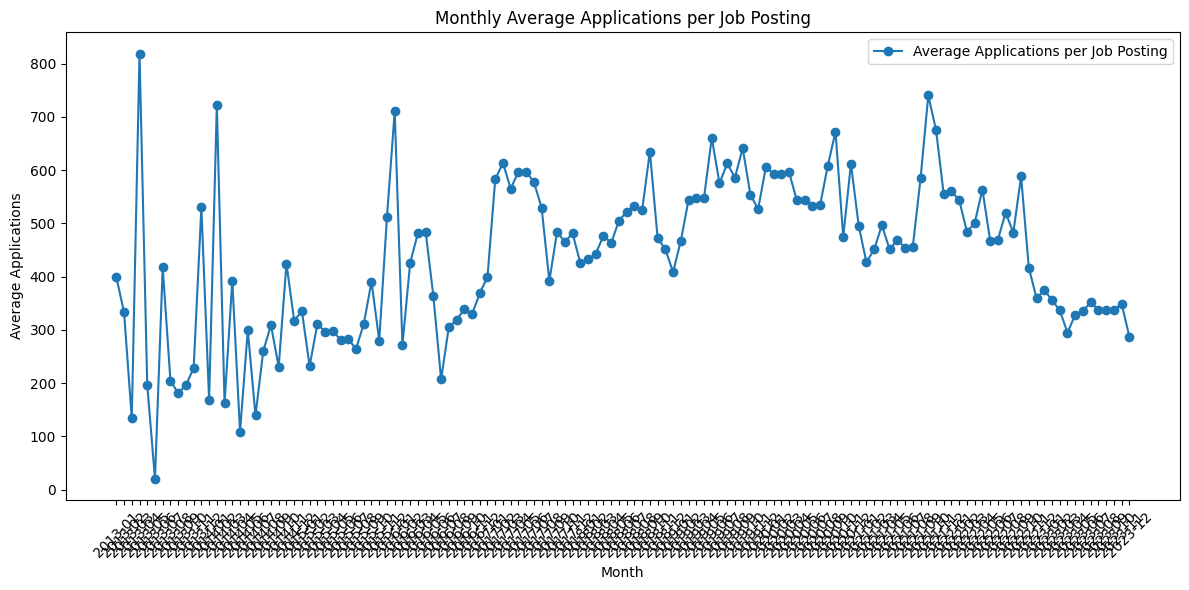

In [ ]:
# 월별 평균 경쟁률

merged_data['cdate'] = pd.to_datetime(merged_data['cdate'], format='mixed')

monthly_avg_applications = merged_data.groupby(merged_data['cdate'].dt.to_period('M'))['application_for_jobposting'].mean()

plt.figure(figsize=(12, 6))

plt.plot(monthly_avg_applications.index.astype(str), monthly_avg_applications, marker='o', label='Average Applications per Job Posting')

plt.xlabel('Month')
plt.ylabel('Average Applications')
plt.title('Monthly Average Applications per Job Posting')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()

plt.show()

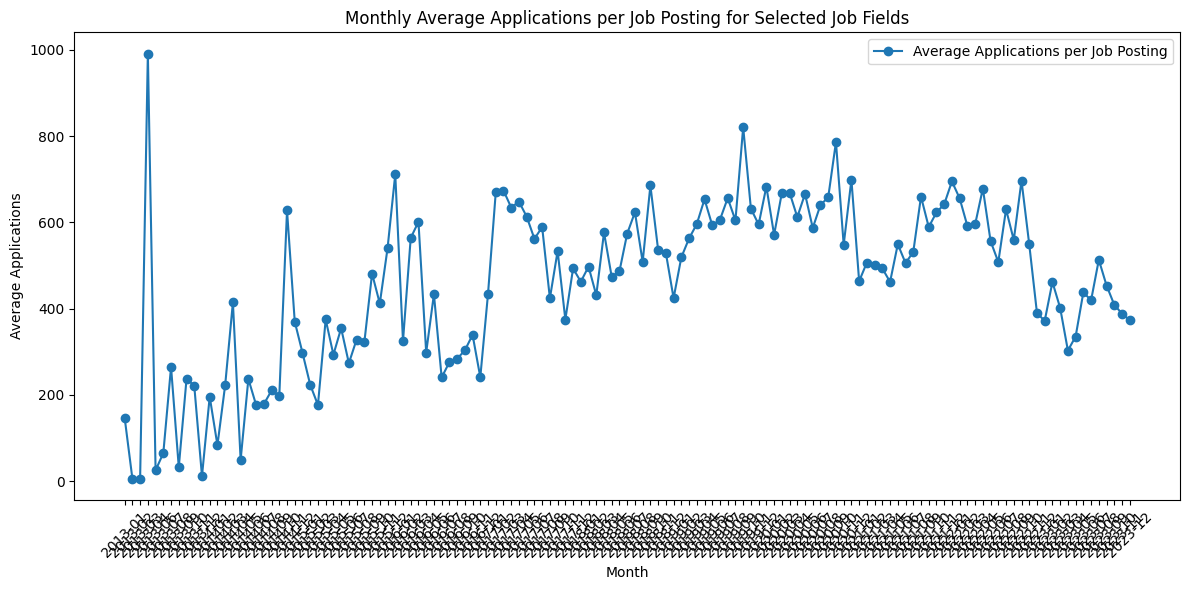

In [ ]:
#월별 평균 경쟁률 (경영지원, 운영, 비즈니스만)

merged_data['cdate'] = pd.to_datetime(merged_data['cdate'], errors='coerce')

filtered_data = merged_data[merged_data['job_field'].isin(['운영', '비즈니스', '디자인'])]

monthly_avg_applications = filtered_data.groupby(filtered_data['cdate'].dt.to_period('M'))['application_for_jobposting'].mean()

plt.figure(figsize=(12, 6))

plt.plot(monthly_avg_applications.index.astype(str), monthly_avg_applications, marker='o', label='Average Applications per Job Posting')

plt.xlabel('Month')
plt.ylabel('Average Applications')
plt.title('Monthly Average Applications per Job Posting for Selected Job Fields')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()

plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_10680\2104428377.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


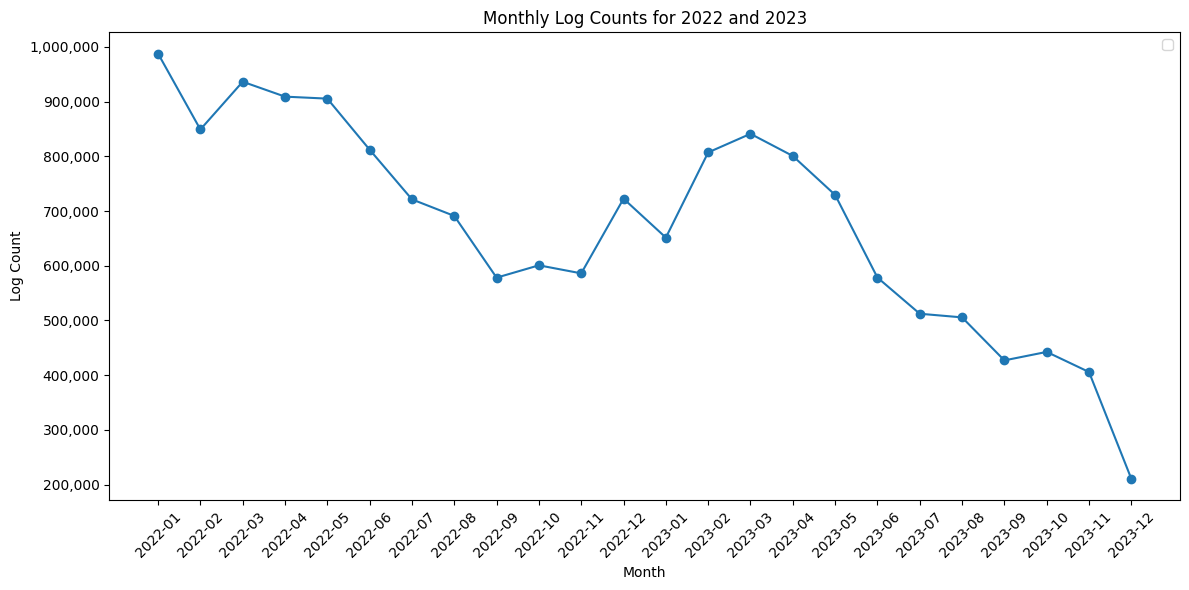

In [ ]:
# 월별 로그 총량 변화

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter


log_data['date'] = pd.to_datetime(log_data['date'])

monthly_log_counts = log_data.groupby(log_data['date'].dt.to_period('M')).size()

plt.figure(figsize=(12, 6))

plt.plot(monthly_log_counts.index.astype(str), monthly_log_counts, marker='o')
plt.xlabel('Month')
plt.ylabel('Log Count')
plt.title('Monthly Log Counts for 2022 and 2023')
plt.xticks(rotation=45)
plt.legend()

plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
plt.gca().yaxis.get_major_formatter().set_scientific(False)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x):,}'))

plt.tight_layout()

# 그래프 출력
plt.show()

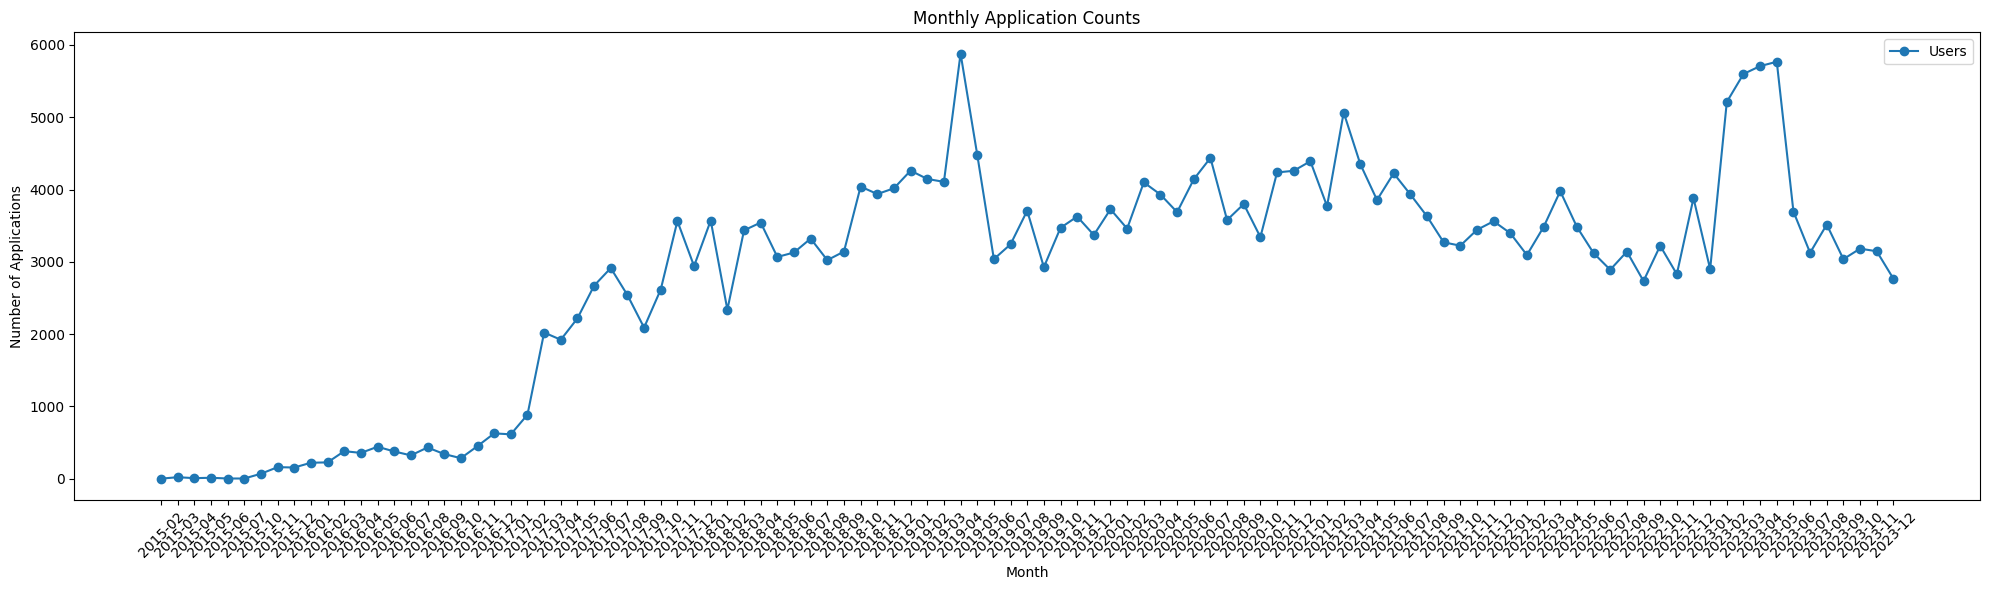

In [ ]:
# 월별 지원자수 변화

application_data['cdate'] = pd.to_datetime(application_data['cdate'], format='mixed')

monthly_application_counts = application_data.groupby(application_data['cdate'].dt.to_period('M'))['user_uuid'].count()

plt.figure(figsize=(20, 6))

plt.plot(monthly_application_counts.index.astype(str), monthly_application_counts, marker='o', label='Users')

plt.xlabel('Month')
plt.ylabel('Number of Applications')
plt.title('Monthly Application Counts')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

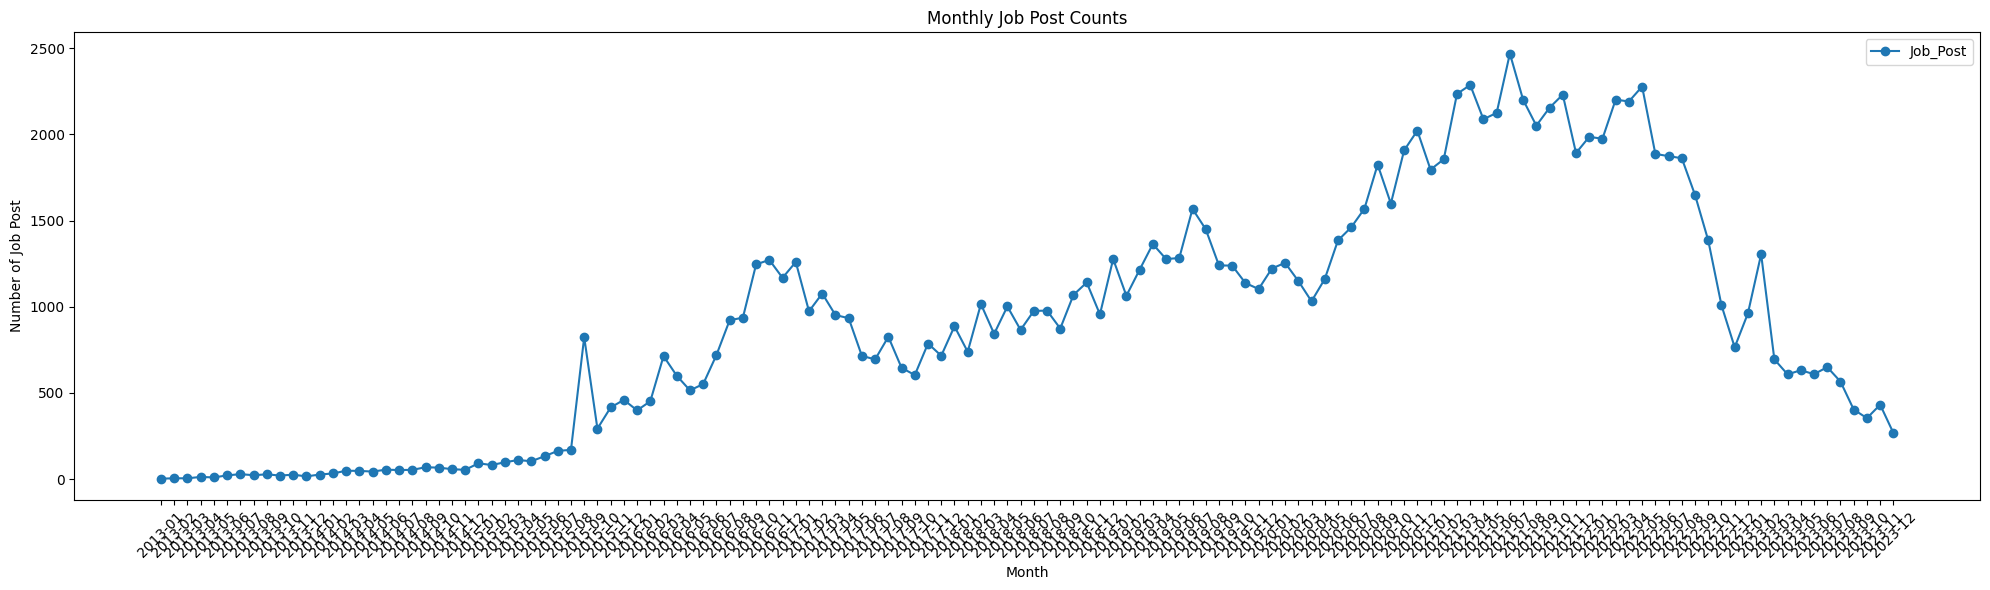

In [ ]:
# 월별 채용공고 수 변화

job_data['cdate'] = pd.to_datetime(job_data['cdate'])
monthly_jobposting_counts = job_data.groupby(job_data['cdate'].dt.to_period('M'))['job_uuid'].count()

plt.figure(figsize=(20, 6))

plt.plot(monthly_jobposting_counts.index.astype(str), monthly_jobposting_counts, marker='o', label='Job_Post')

plt.xlabel('Month')
plt.ylabel('Number of Job Post')
plt.title('Monthly Job Post Counts')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

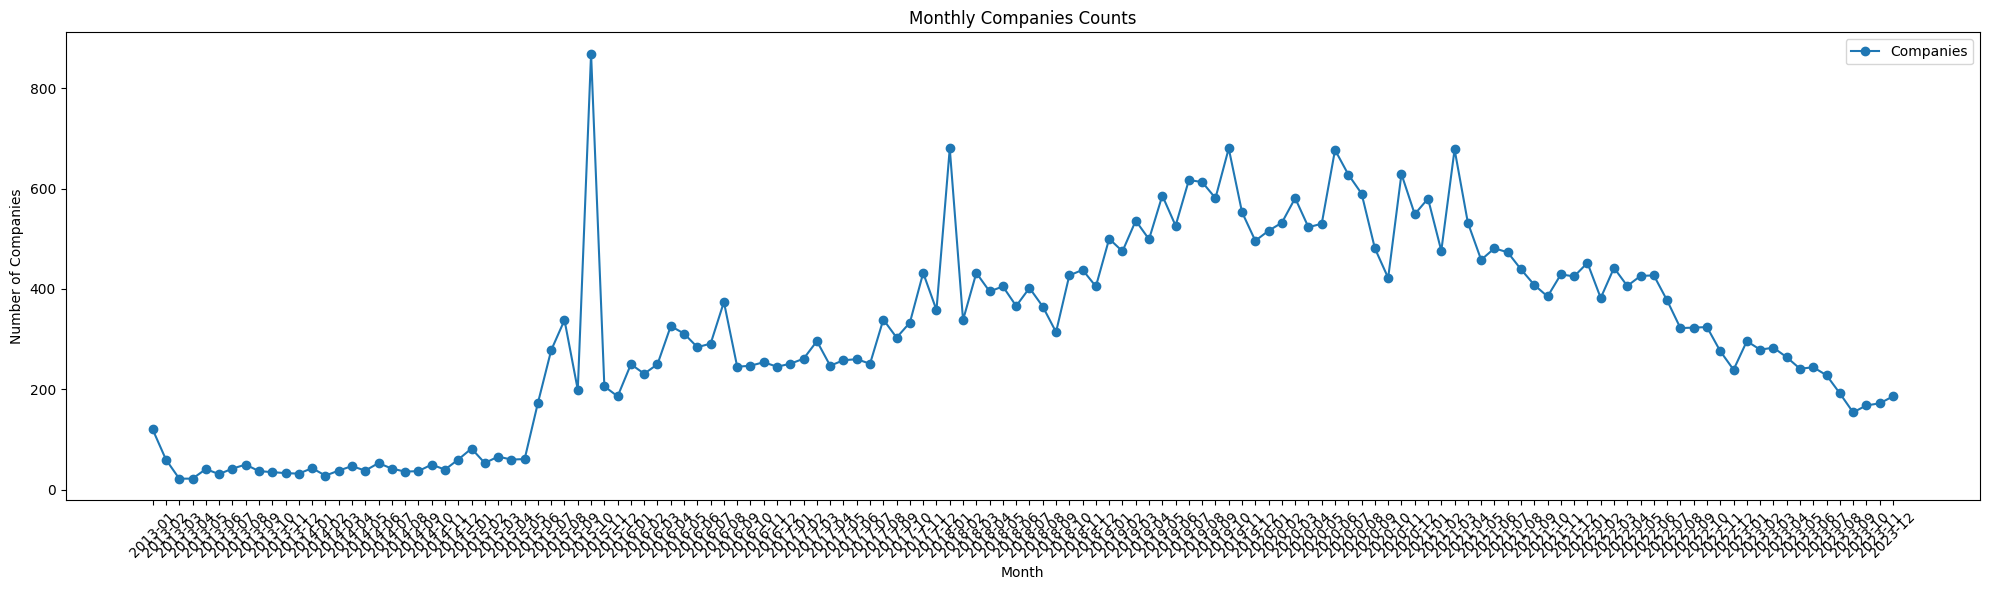

In [ ]:
# 월별 신규등록기업 수 변화

company_data['cdate'] = pd.to_datetime(company_data['cdate'])
monthly_company_counts = company_data.groupby(company_data['cdate'].dt.to_period('M'))['company_uuid'].count()

plt.figure(figsize=(20, 6))

plt.plot(monthly_company_counts.index.astype(str), monthly_company_counts, marker='o', label='Companies')

plt.xlabel('Month')
plt.ylabel('Number of Companies')
plt.title('Monthly Companies Counts')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.show()

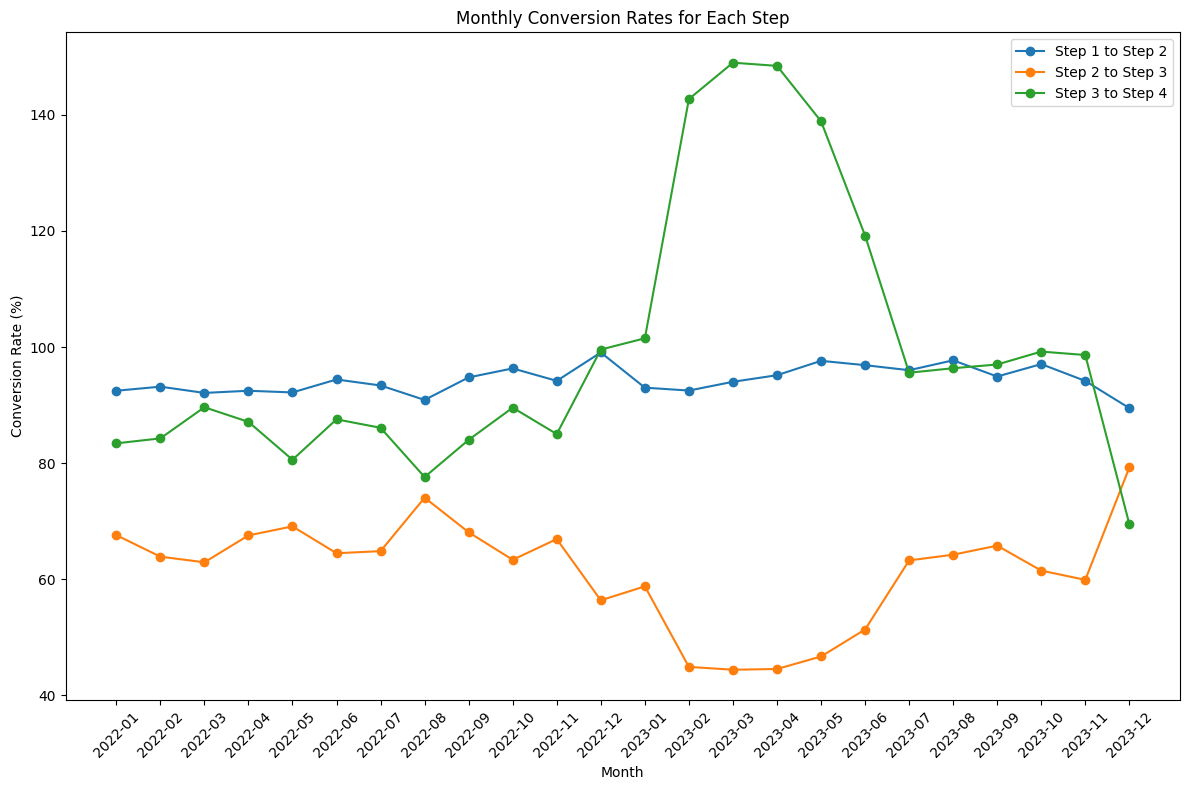

In [ ]:
# 간편지원 스탭별 컨버젼 월별 변화

import pandas as pd
import matplotlib.pyplot as plt

# 'date' 열을 datetime 형식으로 변환
log_data['date'] = pd.to_datetime(log_data['date'])
log_data['date'] = pd.to_datetime(log_data['date'])

# 각 스텝별로 데이터를 필터링합니다.
step1_data = log_data[log_data['URL'].str.contains('api/jobs/id/apply/step1', na=False)]
step2_data = log_data[log_data['URL'].str.contains('api/jobs/id/apply/step2', na=False)]
step3_data = log_data[log_data['URL'].str.contains('api/jobs/id/apply/step3', na=False)]
step4_data = log_data[log_data['URL'].str.contains('api/jobs/id/apply/step4', na=False)]

# 월별로 그룹화하여 각 스텝의 로그 개수를 계산합니다.
monthly_step1_counts = step1_data.groupby(step1_data['date'].dt.to_period('M')).size()
monthly_step2_counts = step2_data.groupby(step2_data['date'].dt.to_period('M')).size()
monthly_step3_counts = step3_data.groupby(step3_data['date'].dt.to_period('M')).size()
monthly_step4_counts = step4_data.groupby(step4_data['date'].dt.to_period('M')).size()

# 컨버전율 계산
conversion_step1_to_step2 = (monthly_step2_counts / monthly_step1_counts).fillna(0) * 100
conversion_step2_to_step3 = (monthly_step3_counts / monthly_step2_counts).fillna(0) * 100
conversion_step3_to_step4 = (monthly_step4_counts / monthly_step3_counts).fillna(0) * 100

# 시각화
plt.figure(figsize=(12, 8))

plt.plot(conversion_step1_to_step2.index.astype(str), conversion_step1_to_step2, marker='o', label='Step 1 to Step 2')
plt.plot(conversion_step2_to_step3.index.astype(str), conversion_step2_to_step3, marker='o', label='Step 2 to Step 3')
plt.plot(conversion_step3_to_step4.index.astype(str), conversion_step3_to_step4, marker='o', label='Step 3 to Step 4')

plt.xlabel('Month')
plt.ylabel('Conversion Rate (%)')
plt.title('Monthly Conversion Rates for Each Step')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()

# 그래프 출력
plt.show()

#### 지원자수, 채용공고수, 신규등록 기업수와 트래픽 사이 분석

                            OLS Regression Results                            
Dep. Variable:             log_counts   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     20.19
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           8.86e-11
Time:                        18:36:42   Log-Likelihood:                -1814.0
No. Observations:                 132   AIC:                             3636.
Df Residuals:                     128   BIC:                             3648.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               9.686e+04   3.85

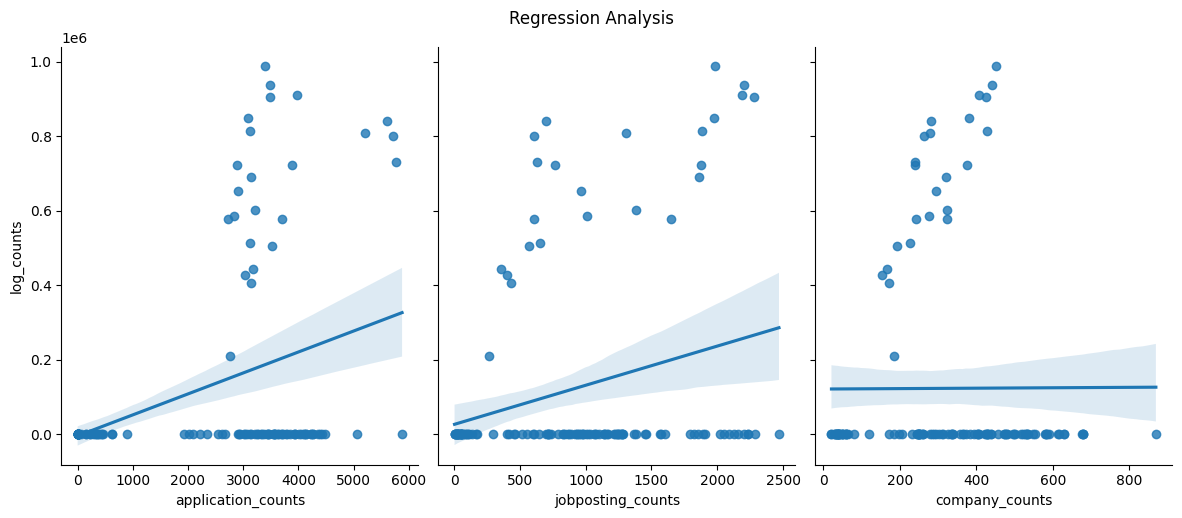

In [ ]:
# 총 트래픽을 종속변수, 지원자.채용공고/신규등록기업수 독립변수 회귀분석석
log_data['date'] = pd.to_datetime(log_data['date'])
application_data['cdate'] = pd.to_datetime(application_data['cdate'])
job_data['cdate'] = pd.to_datetime(job_data['cdate'])
company_data['cdate'] = pd.to_datetime(company_data['cdate'])

monthly_log_counts = log_data.groupby(log_data['date'].dt.to_period('M')).size()

# monthly_application_counts = application_data.groupby(application_data['cdate'].dt.to_period('M'))['user_uuid'].count()
monthly_application_counts = application_data.groupby(application_data['cdate'].dt.to_period('M'))['application_uuid'].count()

monthly_jobposting_counts = job_data.groupby(job_data['cdate'].dt.to_period('M'))['job_uuid'].count()

monthly_company_counts = company_data.groupby(company_data['cdate'].dt.to_period('M'))['company_uuid'].count()

step4_data = log_data[log_data['URL'].str.contains('jobs/id/apply/step4|api/jobs/id/apply/step4', na=False)]
complete_data = log_data[log_data['URL'].str.contains('jobs/id/apply/complete|api/jobs/id/apply/complete', na=False)]

monthly_step4_counts = step4_data.groupby(step4_data['date'].dt.to_period('M')).size()
monthly_complete_counts = complete_data.groupby(complete_data['date'].dt.to_period('M')).size()



df = pd.DataFrame({
    'log_counts': monthly_log_counts,
    'application_counts': monthly_application_counts,
    'jobposting_counts': monthly_jobposting_counts,
    'company_counts': monthly_company_counts
}).fillna(0)

X = df[['application_counts', 'jobposting_counts', 'company_counts']]
y = df['log_counts']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

sns.pairplot(df, x_vars=['application_counts', 'jobposting_counts', 'company_counts'], y_vars='log_counts', height=5, aspect=0.8, kind='reg')
plt.suptitle('Regression Analysis', y=1.02)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                    mau   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     20.33
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           7.73e-11
Time:                        18:36:45   Log-Likelihood:                -1176.5
No. Observations:                 132   AIC:                             2361.
Df Residuals:                     128   BIC:                             2373.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                868.9578    307

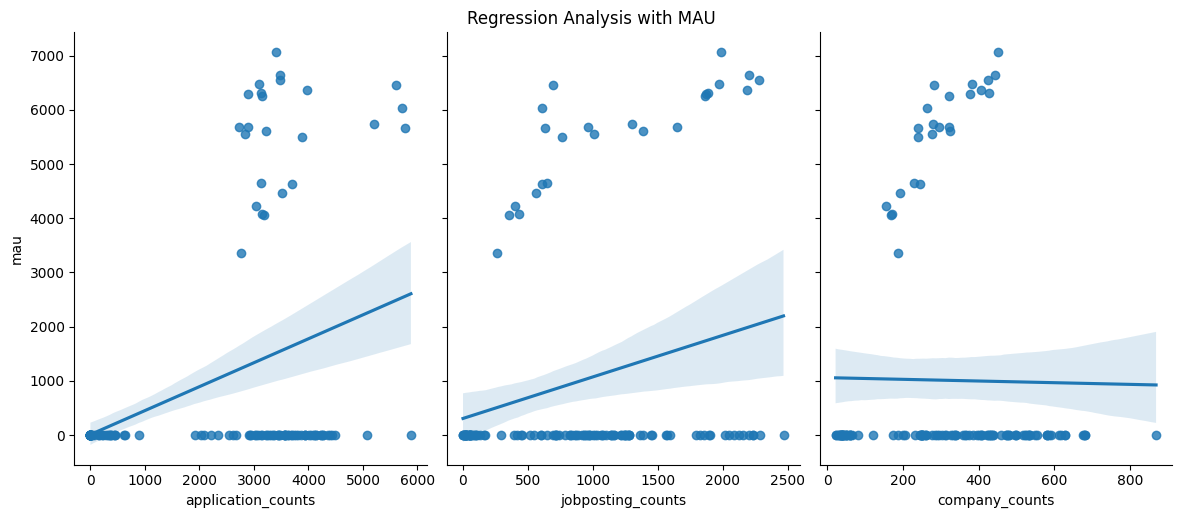

In [ ]:
# MAU를 종속변수, 지원자/채용공고/신규등록기업수 독립변수 회귀분석

monthly_mau = log_data.groupby(log_data['date'].dt.to_period('M'))['user_uuid'].nunique()

monthly_application_counts = application_data.groupby(application_data['cdate'].dt.to_period('M'))['application_uuid'].count()

monthly_jobposting_counts = job_data.groupby(job_data['cdate'].dt.to_period('M'))['job_uuid'].count()

monthly_company_counts = company_data.groupby(company_data['cdate'].dt.to_period('M'))['company_uuid'].count()

df = pd.DataFrame({
    'mau': monthly_mau,
    'application_counts': monthly_application_counts,
    'jobposting_counts': monthly_jobposting_counts,
    'company_counts': monthly_company_counts
}).fillna(0)

# 회귀분석
X = df[['application_counts', 'jobposting_counts', 'company_counts']]
y = df['mau']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

sns.pairplot(df, x_vars=['application_counts', 'jobposting_counts', 'company_counts'], y_vars='mau', height=5, aspect=0.8, kind='reg')
plt.suptitle('Regression Analysis with MAU', y=1.02)
plt.show()

In [ ]:
# 채용공고수 <-> 지원자수, 신규기업등록수 회귀분석
X = df[['application_counts', 'company_counts']]
y = df['jobposting_counts']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      jobposting_counts   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     103.2
Date:                Thu, 30 Jan 2025   Prob (F-statistic):           1.74e-27
Time:                        18:36:45   Log-Likelihood:                -987.79
No. Observations:                 132   AIC:                             1982.
Df Residuals:                     129   BIC:                             1990.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 49.6090     73

In [ ]:
# # 지원자수와 간편지원수의 다중공선성에 따른 라쏘회귀분석 결과

# from sklearn.linear_model import LassoCV

# X = df[['application_counts', 'jobposting_counts', 'company_counts', 'step4_counts']]
# y = df['log_counts']

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# lasso = LassoCV(cv=5, random_state=0)  # 5-fold cross-validation
# lasso.fit(X_scaled, y)

# print(f"Optimal alpha: {lasso.alpha_}")
# print("Coefficients:")
# print(dict(zip(X.columns, lasso.coef_)))

# print("\nIntercept:", lasso.intercept_)
# print("R-squared:", lasso.score(X_scaled, y))

In [ ]:
# 간편지원(complete) 과 지원자수, 채용공고수 회귀 분석

monthly_application_counts = application_data.groupby(application_data['cdate'].dt.to_period('M'))['application_uuid'].count()

df = pd.DataFrame({
    'mau': monthly_mau,
    'application_counts': monthly_application_counts,
    'jobposting_counts': monthly_jobposting_counts,
    'complete_counts': monthly_complete_counts,
    'step4_counts' : monthly_step4_counts
}).fillna(0)

X = df['complete_counts']
X = sm.add_constant(X)

y = df['jobposting_counts']
model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      jobposting_counts   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.904
Date:                Thu, 30 Jan 2025   Prob (F-statistic):             0.0907
Time:                        18:36:45   Log-Likelihood:                -1049.4
No. Observations:                 132   AIC:                             2103.
Df Residuals:                     130   BIC:                             2109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             945.6407     61.925     

In [ ]:
# 최고의 결과를 낸 분석 : T-Test, 간편지원 이용 유저의 평균 지원수 vs 아닌 그룹의 지원수

easy_apply_users = log_data_df[log_data_df['URL'].str.contains('jobs/id/apply/complete|api/jobs/id/apply/complete', na=False)]['user_uuid'].unique()
easy_apply_counts = application_data[application_data['user_uuid'].isin(easy_apply_users)].groupby('user_uuid')['application_uuid'].count()
non_easy_apply_counts = application_data[~application_data['user_uuid'].isin(easy_apply_users)].groupby('user_uuid')['application_uuid'].count()

levene_stat, levene_p_value = stats.levene(easy_apply_counts, non_easy_apply_counts)
print(f"F통계량: {levene_stat}, P-value: {levene_p_value}")

equal_var = levene_p_value > 0.05

t_stat, p_value = stats.ttest_ind(easy_apply_counts, non_easy_apply_counts, equal_var=equal_var)
print(f"T통계량: {t_stat}, P-value: {p_value}")

easy_apply_mean = easy_apply_counts.mean()
non_easy_apply_mean = non_easy_apply_counts.mean()

print(f"간편지원 이용 유저의 평균 지원수 : {easy_apply_mean}")
print(f"간편지원 미이용 유저의 평균 지원수 : {non_easy_apply_mean}")

F통계량: 532.8471272057574, P-value: 4.633879948458805e-117
T통계량: 9.655616070872101, P-value: 9.05039290084241e-22
간편지원 이용 유저의 평균 지원수 : 21.977839335180054
간편지원 미이용 유저의 평균 지원수 : 6.798010871513052


#### A/B 테스트 시도 코드들

In [ ]:
# apply 평균 방문자수 계산

log_data['date'] = pd.to_datetime(log_data['date'])

apply_data = log_data[log_data['URL'].str.contains('jobs/id/apply|api/jobs/id/apply', na=False)]

weekly_apply_counts = apply_data.resample('W-Mon', on='date').size()
weekly_apply_mean = weekly_apply_counts.mean()

print(f"평균 주간 방문자수 (apply): {weekly_apply_mean}")

평균 주간 방문자수 (apply): 9931.380952380952


In [ ]:
# step2 평균 방문자 수 계산
step2_data = log_data_df[log_data_df['URL'].str.contains('jobs/id/apply/step2|api/jobs/id/apply/step2', na=False)]
step2_mean_visitors = step2_data.groupby(step2_data['date'].dt.to_period('W')).size().mean()

print(f"평균 주간 방문자수 (step2): {step2_mean_visitors}")

평균 주간 방문자수 (step2): 2819.7714285714287


In [ ]:
# 기존 퍼널 차트
apply_users = set(apply_data['user_uuid'])
step1_users = set(step1_data['user_uuid'])
step2_users = set(step2_data['user_uuid'])
step3_users = set(step3_data['user_uuid'])
step4_users = set(step4_data['user_uuid'])
complete_users = set(complete_data['user_uuid'])

step1_from_apply = step1_users.intersection(apply_users)
step2_from_step1 = step2_users.intersection(step1_users)
step3_from_step2 = step3_users.intersection(step2_users)
step4_from_step3 = step4_users.intersection(step3_users)
complete_from_step4 = complete_users.intersection(step4_users)

apply_count = len(apply_users)
step1_count = len(step1_from_apply)
step2_count = len(step2_from_step1)
step3_count = len(step3_from_step2)
step4_count = len(step4_from_step3)
complete_count = len(complete_from_step4)

steps = ['apply', 'Step 1', 'Step 2', 'Step 3', 'Step 4', 'complete']
counts = [apply_count, step1_count, step2_count, step3_count, step4_count, complete_count]

fig = go.Figure(go.Funnel(
    y = steps,
    x = counts,
    textinfo = "value+percent initial"
))

fig.show()

funnel_data = pd.DataFrame({
    'Step': steps,
    'Count': counts
})

In [ ]:
# 개선된 퍼널 차트
apply_users = set(apply_data['user_uuid'])
step1_users = set(step1_data['user_uuid'])
step2_users = set(step2_data['user_uuid'])
step3_users = set(step3_data['user_uuid'])
step4_users = set(step4_data['user_uuid'])
complete_users = set(complete_data['user_uuid'])

step1_from_apply = step1_users.intersection(apply_users)
step2_from_step1 = step2_users.intersection(step1_users)
step3_from_step2 = step3_users.intersection(step2_users)
step4_from_step3 = step4_users.intersection(step3_users)
complete_from_step4 = complete_users.intersection(step4_users)

apply_count = len(apply_users)
step1_count = len(step1_from_apply)
step2_count = len(step2_from_step1)
step3_count = len(step3_from_step2)
step4_count = len(step4_from_step3)
complete_count = len(complete_from_step4)

abtest_step2_3_before = 76.49 / 100
abtest_complete_before = 27.93 / 100

abtest_step2_3_after = 82.06 / 100
abtest_complete_after = 34.53 / 100

increase_ratio_step2_3 = abtest_step2_3_after / abtest_step2_3_before
increase_ratio_complete = abtest_complete_after / abtest_complete_before

new_step3_count = step3_count * increase_ratio_step2_3

new_complete_count = complete_count * increase_ratio_complete

increase_in_complete_count = new_complete_count - complete_count

print(f"New complete count: {new_complete_count}")
print(f"Increase in complete count: {increase_in_complete_count}")

steps = ['apply', 'Step 1', 'Step 2', 'Step 3', 'Step 4', 'complete']
counts = [apply_count, step1_count, step2_count, new_step3_count, step4_count, new_complete_count]

fig = go.Figure(go.Funnel(
    y = steps,
    x = counts,
    textinfo = "value+percent initial"
))

fig.show()

funnel_data = pd.DataFrame({
    'Step': steps,
    'Count': counts
})

New complete count: 4009.3372717508055
Increase in complete count: 766.3372717508055


In [ ]:
# 주간 퍼널별 평균 방문자수 계산

log_data_df['date'] = pd.to_datetime(log_data_df['date'])

apply_data = log_data_df[log_data_df['URL'].str.contains('jobs/id/apply|api/jobs/id/apply', na=False)]
step1_data = log_data_df[log_data_df['URL'].str.contains('jobs/id/apply/step1|api/jobs/id/apply/step1', na=False)]
step2_data = log_data_df[log_data_df['URL'].str.contains('jobs/id/apply/step2|api/jobs/id/apply/step2', na=False)]
step3_data = log_data_df[log_data_df['URL'].str.contains('jobs/id/apply/step3|api/jobs/id/apply/step3', na=False)]
step4_data = log_data_df[log_data_df['URL'].str.contains('jobs/id/apply/step4|api/jobs/id/apply/step4', na=False)]
complete_data = log_data_df[log_data_df['URL'].str.contains('jobs/id/apply/complete', na=False)]

apply_users = set(apply_data['user_uuid'])
step1_users = set(step1_data['user_uuid'])
step2_users = set(step2_data['user_uuid'])
step3_users = set(step3_data['user_uuid'])
step4_users = set(step4_data['user_uuid'])
complete_users = set(complete_data['user_uuid'])

step1_from_apply = step1_users.intersection(apply_users)
step2_from_step1 = step2_users.intersection(step1_users)
step3_from_step2 = step3_users.intersection(step2_users)
step4_from_step3 = step4_users.intersection(step3_users)
complete_from_step4 = complete_users.intersection(step4_users)

apply_count = len(apply_users)
step1_count = len(step1_from_apply)
step2_count = len(step2_from_step1)
step3_count = len(step3_from_step2)
step4_count = len(step4_from_step3)
complete_count = len(complete_from_step4)

weekly_apply_counts = apply_data.set_index('date').resample('W-Mon')['user_uuid'].nunique()
weekly_step1_counts = step1_data.set_index('date').resample('W-Mon')['user_uuid'].nunique()
weekly_step2_counts = step2_data.set_index('date').resample('W-Mon')['user_uuid'].nunique()
weekly_step3_counts = step3_data.set_index('date').resample('W-Mon')['user_uuid'].nunique()
weekly_step4_counts = step4_data.set_index('date').resample('W-Mon')['user_uuid'].nunique()
weekly_complete_counts = complete_data.set_index('date').resample('W-Mon')['user_uuid'].nunique()

weekly_apply_mean = weekly_apply_counts.mean()
weekly_step1_mean = weekly_step1_counts.mean()
weekly_step2_mean = weekly_step2_counts.mean()
weekly_step3_mean = weekly_step3_counts.mean()
weekly_step4_mean = weekly_step4_counts.mean()
weekly_complete_mean = weekly_complete_counts.mean()

steps = ['apply', 'Step 1', 'Step 2', 'Step 3', 'Step 4', 'complete']
weekly_means = [weekly_apply_mean, weekly_step1_mean, weekly_step2_mean, weekly_step3_mean, weekly_step4_mean, weekly_complete_mean]

fig = go.Figure(go.Funnel(
    y = steps,
    x = weekly_means,
    textinfo = "value+percent initial"
))

fig.show()

funnel_data = pd.DataFrame({
    'Step': steps,
    'Weekly Average Visitors': weekly_means
})

C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 54943 (\N{HANGUL SYLLABLE HOES}) missing from font(s) DejaVu Sans.

C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.

C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.

C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.

C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.

C:\Users\Home\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarn

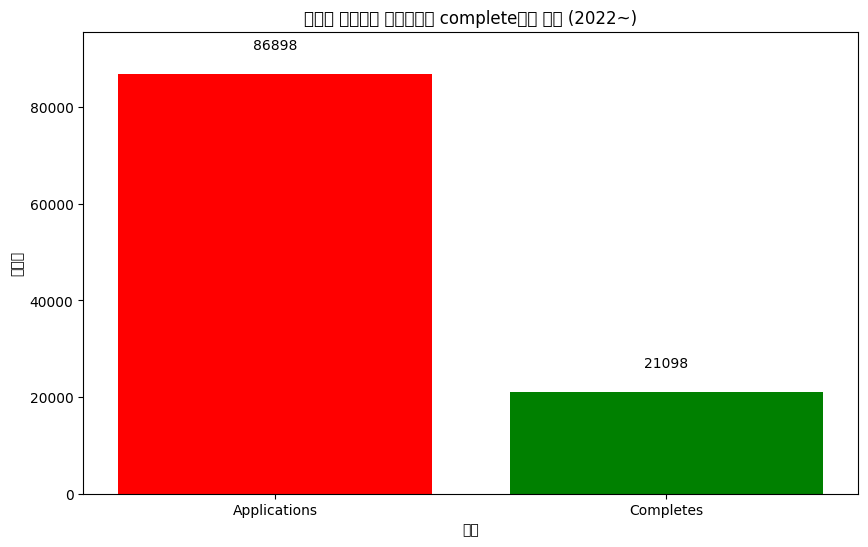

In [ ]:
# application_uuid와 complete user_uuid 값 비교 (2022~)
application_data['cdate'] = pd.to_datetime(application_data['cdate'])

application_data_2022 = application_data[application_data['cdate'] >= '2022-01-01']

application_count_2022 = application_data_2022['application_uuid'].nunique()
complete_count_2022 = complete_data['user_uuid'].count()

comparison_df = pd.DataFrame({
    'Category': ['Applications', 'Completes'],
    'Count': [application_count_2022, complete_count_2022]
})

plt.figure(figsize=(10, 6))
plt.bar(comparison_df['Category'], comparison_df['Count'], color=['red', 'green'])

for i, count in enumerate(comparison_df['Count']):
    plt.text(i, count + 0.05 * max(comparison_df['Count']), str(count), ha='center', va='bottom')

plt.xlabel('구분')
plt.ylabel('횟수')
plt.title('지원자 데이터의 지원횟수와 complete수의 비교 (2022~)')
plt.ylim(0, max(comparison_df['Count']) * 1.1)
plt.show()

In [ ]:
# 월별 간편지원 횟수

apply_data['apply_date'] = pd.to_datetime(apply_data['timestamp'])
step1_data['step1_date'] = pd.to_datetime(step1_data['timestamp'])
step2_data['step2_date'] = pd.to_datetime(step2_data['timestamp'])
step3_data['step3_date'] = pd.to_datetime(step3_data['timestamp'])
step4_data['step4_date'] = pd.to_datetime(step4_data['timestamp'])
complete_data['complete_date'] = pd.to_datetime(complete_data['timestamp'])

monthly_counts = {
    "Apply": apply_data.set_index("apply_date").resample("M").size(),
    "Step1": step1_data.set_index("step1_date").resample("M").size(),
    "Step2": step2_data.set_index("step2_date").resample("M").size(),
    "Step3": step3_data.set_index("step3_date").resample("M").size(),
    "Step4": step4_data.set_index("step4_date").resample("M").size(),
    "Complete": complete_data.set_index("complete_date").resample("M").size(),
}

all_months = sorted(set().union(*[counts.index for counts in monthly_counts.values()]))

for key in monthly_counts:
    monthly_counts[key] = monthly_counts[key].reindex(all_months, fill_value=0)

monthly_log_df = pd.DataFrame({
    "Month": all_months,
    **{key: counts.values for key, counts in monthly_counts.items()}
})

monthly_log_df

monthly_log_df.to_csv('monthly_counts_filtered.csv', index=False)

print("CSV 저장 완료: monthly_counts_filtered.csv")

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\2593555280.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\2593555280.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\2593555280.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

CSV 저장 완료: monthly_counts_filtered.csv


C:\Users\Home\AppData\Local\Temp\ipykernel_19044\2593555280.py:14: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [ ]:
# 월별 간편지원 완료 유저수

apply_data['apply_date'] = pd.to_datetime(apply_data['timestamp'])
step1_data['step1_date'] = pd.to_datetime(step1_data['timestamp'])
step2_data['step2_date'] = pd.to_datetime(step2_data['timestamp'])
step3_data['step3_date'] = pd.to_datetime(step3_data['timestamp'])
step4_data['step4_date'] = pd.to_datetime(step4_data['timestamp'])
complete_data['complete_date'] = pd.to_datetime(complete_data['timestamp'])

monthly_apply_counts = apply_data.set_index('apply_date').resample('M')['user_uuid'].nunique()
monthly_step1_counts = step1_data.set_index('step1_date').resample('M')['user_uuid'].nunique()
monthly_step2_counts = step2_data.set_index('step2_date').resample('M')['user_uuid'].nunique()
monthly_step3_counts = step3_data.set_index('step3_date').resample('M')['user_uuid'].nunique()
monthly_step4_counts = step4_data.set_index('step4_date').resample('M')['user_uuid'].nunique()
monthly_complete_counts = complete_data.set_index('complete_date').resample('M')['user_uuid'].nunique()

step1_from_apply = complete_data[complete_data['user_uuid'].isin(step1_data['user_uuid'])].set_index('complete_date').resample('M')['user_uuid'].nunique()
step2_from_step1 = complete_data[complete_data['user_uuid'].isin(step2_data['user_uuid'])].set_index('complete_date').resample('M')['user_uuid'].nunique()
step3_from_step2 = complete_data[complete_data['user_uuid'].isin(step3_data['user_uuid'])].set_index('complete_date').resample('M')['user_uuid'].nunique()
step4_from_step3 = complete_data[complete_data['user_uuid'].isin(step4_data['user_uuid'])].set_index('complete_date').resample('M')['user_uuid'].nunique()
complete_from_step4 = complete_data.set_index('complete_date').resample('M')['user_uuid'].nunique()  # Complete는 그대로 유지

all_months = monthly_complete_counts.index

monthly_apply_counts = monthly_apply_counts.reindex(all_months, fill_value=0)
step1_from_apply = step1_from_apply.reindex(all_months, fill_value=0)
step2_from_step1 = step2_from_step1.reindex(all_months, fill_value=0)
step3_from_step2 = step3_from_step2.reindex(all_months, fill_value=0)
step4_from_step3 = step4_from_step3.reindex(all_months, fill_value=0)
complete_from_step4 = complete_from_step4.reindex(all_months, fill_value=0)

monthly_counts_df = pd.DataFrame({
    'Month': all_months,
    'Apply': monthly_apply_counts.values,
    'Step1': step1_from_apply.values,
    'Step2': step2_from_step1.values,
    'Step3': step3_from_step2.values,
    'Step4': step4_from_step3.values,
    'Complete': complete_from_step4.values
})

monthly_counts_df

monthly_counts_df.to_csv('monthly_user_counts_filtered.csv', index=False)

print("CSV 저장 완료: monthly_user_counts_filtered.csv")

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\327074731.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\327074731.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\327074731.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

CSV 저장 완료: monthly_user_counts_filtered.csv


C:\Users\Home\AppData\Local\Temp\ipykernel_19044\327074731.py:13: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\327074731.py:15: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\327074731.py:16: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\327074731.py:17: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\327074731.py:18: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\Home\AppData\Local\Temp\ipykernel_19044\327074731.py:19: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

# 📌 공고 상세 분석

## 다중회귀분석으로 회사 지원 수에 영향이 있는 요소들을 분석

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

application_df = pd.read_csv('job_data/Application.csv', encoding='cp949')
job_df = pd.read_csv('job_data/Job.csv', encoding='cp949')
company_fund_df = pd.read_csv('job_data/CompanyFund.csv', encoding='cp949')
bookmark_df = pd.read_csv('job_data/JobBookmark.csv', encoding='cp949')

## 데이터 전처리 (job_df)
1. 채용 시작일의 결측값에는 등록 날짜로 채움.
2. 채용 마감일의 결측치 제거.
3. 분석에 불필요한 열 제거.

In [ ]:
# 등록 날짜의 연월일만 나와 있는 cdate_date 열 생성.
job_df['cdate_date'] = pd.to_datetime(job_df['cdate']).dt.date

# start_date의 결측값을 등록 날짜로 채움.
job_df['start_date'] = job_df['start_date'].fillna(job_df['cdate_date'])

# cdate_date 열 제거
job_df.drop(columns=['cdate_date'], inplace=True)


In [ ]:
# 결측치 제거
job_df.dropna(inplace=True)

In [ ]:
# 분석에 불필요한 열 제거
job_df.drop(columns=['Column1','cdate','mdate'], inplace=True)
job_df

,job_field,career_type_string,start_date,end_date,allow_remote,can_show_salary,job_uuid,company_uuid
0,SW 개발,"신입,경력,인턴",2020-11-25,2020-11-25,1,0,764292b0-53f8-4f14-ac83-6eafc7a6a18d,daa34559-fc42-47f6-b5c6-cc6171404f37
1,HW 개발,인턴,2020-12-03,2020-12-04,1,0,b2b598d6-9ca3-4eb4-ac9c-bb57a6dad2ad,daa34559-fc42-47f6-b5c6-cc6171404f37
2,디자인,"신입,경력,인턴",2019-06-13,2019-06-21,0,0,017f4d7d-91a9-4ef7-9dd7-afabf7cbd26d,d4e7e647-8f85-4e7f-8609-7173cc240e18
3,마케팅,경력,2019-06-14,2019-07-15,0,0,41707ef1-f733-4f58-bb29-0b2e6175cf5e,d4e7e647-8f85-4e7f-8609-7173cc240e18
4,운영,"신입,경력",2019-07-02,2019-08-31,0,0,d0aa0eef-65d2-4e00-8177-968a2dc52009,d4e7e647-8f85-4e7f-8609-7173cc240e18
...,...,...,...,...,...,...,...,...
144240,운영,경력,2019-12-09,2019-12-20,0,1,ab4a46d4-7cec-4275-8ad6-94971e4c4942,f0939862-3174-4b0b-b440-3cdf1e260947
144243,SW 개발,경력,2022-06-07,2022-06-25,1,1,03f1d118-22e3-4659-aa66-565d3e963176,ef64f626-9b9b-46b5-93d8-df575be06ffa
144244,운영,"신입,경력",2023-12-23,2024-01-22,0,1,40308e61-c272-45bc-af2f-0e2e3a29f152,1c74eb98-ad0e-4274-bf91-5a76969b0aa8
144245,운영,"신입,인턴",2023-12-28,2024-01-09,0,1,e4ae1cdb-4ffc-48da-bc91-507b1f97a46f,1c74eb98-ad0e-4274-bf91-5a76969b0aa8


## 데이터 전처리 (company_fund_df)
1. fund_date를 기간으로 나눔. fund_start(투자 받은 날), fund_end(다음 투자 받은 날)
2. 불필요한 열 제거.

In [ ]:
company_fund_df['fund_date'] = pd.to_datetime(company_fund_df['fund_date'], errors='coerce')

# company_uuid와 fund_date를 기준으로 재정렬
company_fund_df = company_fund_df.sort_values(by=['company_uuid', 'fund_date'])

# fund_start와 fund_end 열 생성
company_fund_df['fund_start'] = company_fund_df['fund_date']
company_fund_df['fund_end'] = company_fund_df.groupby('company_uuid')['fund_date'].shift(-1)

# fund_end의 결측값들은 오늘 날짜로 채움.
today_date = datetime.today().date()
company_fund_df['fund_end'] = company_fund_df['fund_end'].dt.date.fillna(today_date)

In [ ]:
# 불필요한 열 제거
company_fund_df.drop(columns=['Column1','fund_date','raised','currency'], inplace=True)

In [ ]:
company_fund_df

,round_type,company_uuid,fund_start,fund_end
834,투자 단계 비공개,0000fda1-54e9-43ff-8c7b-8dcdf5efdb2a,2018-07-25,2018-09-07
835,투자 단계 비공개,0000fda1-54e9-43ff-8c7b-8dcdf5efdb2a,2018-09-07,2019-06-17
836,투자 단계 비공개,0000fda1-54e9-43ff-8c7b-8dcdf5efdb2a,2019-06-17,2019-07-25
833,Seed,0000fda1-54e9-43ff-8c7b-8dcdf5efdb2a,2019-07-25,2025-01-22
7169,투자 단계 비공개,00027545-e75b-4b62-9d97-02eaa67618e7,2022-02-25,2025-01-22
...,...,...,...,...
794,Seed,ffbbcb10-9c1a-4bbb-a939-c44c39bc7539,2019-05-01,2019-07-08
795,투자 단계 비공개,ffbbcb10-9c1a-4bbb-a939-c44c39bc7539,2019-07-08,2025-01-22
3629,Seed,fff6b88c-bbca-4637-a593-c6cc96b3e099,2021-11-13,2025-01-22
1271,Seed,fffdf439-a33f-4fd3-8168-718d5cdf9bdc,2020-10-20,2020-10-20


## 데이터 EDA
1. application_df를 사용하여 각 회사별 지원자 수를 구함.
2. 모든 데이터셋을 병합.

In [ ]:
# 각 채용별 지원자 수
applicant_counts_df = application_df.groupby('job_uuid').size().reset_index(name='applicant_count')

applicant_counts_df

,job_uuid,applicant_count
0,00007ccc-8398-4461-b6d9-9878dadb531b,2
1,000106ea-0a89-4bf6-a640-3469c34c8c99,2
2,00016572-cd65-4fc3-9b49-7f2f8cd7ca7a,2
3,00016e77-ed17-47c6-b677-dcd7c96c6dcb,1
4,0001a590-5097-41f6-8ac3-32d53f8fd660,2
...,...,...
72403,fffb8462-73a7-4587-9a75-e3bd7f3b7ca0,3
72404,fffbbf0a-de58-445f-9dd4-d42a4733bbc5,1
72405,fffd0d11-a025-44a5-8fd9-7f82d242cff0,4
72406,fffd3bf7-b785-478d-b866-7d7fa125e378,3


In [ ]:
# applicant_counts_df와 job_df를 병합.
job_applicant_df = pd.merge(applicant_counts_df, job_df, on='job_uuid', how='inner')
job_applicant_df

,job_uuid,applicant_count,job_field,career_type_string,start_date,end_date,allow_remote,can_show_salary,company_uuid
0,00007ccc-8398-4461-b6d9-9878dadb531b,2,SW 개발,경력,2021-05-03,2021-08-20,0,1,06d5ec48-9f98-4780-a232-88965def3e5e
1,000106ea-0a89-4bf6-a640-3469c34c8c99,2,마케팅,경력,2023-04-28,2023-06-05,0,0,2a2f6bcb-9cef-408a-9424-e1b3898da251
2,00016572-cd65-4fc3-9b49-7f2f8cd7ca7a,2,경영지원,경력,2023-01-17,2023-02-05,0,0,9de72f52-dc33-4400-a11e-1bd08672b2ec
3,0001a590-5097-41f6-8ac3-32d53f8fd660,2,SW 개발,"신입,경력",2021-06-02,2021-06-30,0,0,ddf7d0a7-92c8-4498-a4e1-6821a21c8617
4,000245cd-3d91-4db6-a163-06abdde59637,8,SW 개발,경력,2019-09-24,2020-02-13,0,1,9f356c17-4a06-4955-aee6-d75719ad76c5
...,...,...,...,...,...,...,...,...,...
57961,fffa63d2-35c7-4023-9f94-be1c533be6f7,1,기획/PM,경력,2019-08-12,2019-08-29,0,1,0035a411-212f-4b0d-b08e-2d3828ed0b0a
57962,fffb8462-73a7-4587-9a75-e3bd7f3b7ca0,3,SW 개발,"신입,경력",2019-02-20,2019-03-22,1,1,f5e8e9f2-0908-4755-b719-a642bc8ff885
57963,fffbbf0a-de58-445f-9dd4-d42a4733bbc5,1,디자인,경력,2019-01-07,2019-01-25,1,1,b311f71a-67b8-418b-b53b-fc46f0b67475
57964,fffd3bf7-b785-478d-b866-7d7fa125e378,3,SW 개발,경력,2022-08-12,2022-10-19,1,1,034f0ce8-6171-4be7-903c-49f230a734f8


In [ ]:
merged_df = job_applicant_df.merge(company_fund_df, on='company_uuid', suffixes=('_df1', '_df2'))

merged_df['start_date'] = pd.to_datetime(merged_df['start_date'], errors='coerce')
merged_df['end_date'] = pd.to_datetime(merged_df['end_date'], errors='coerce')
merged_df['fund_start'] = pd.to_datetime(merged_df['fund_start'], errors='coerce')
merged_df['fund_end'] = pd.to_datetime(merged_df['fund_end'], errors='coerce')

In [ ]:
# 채용기간에 그 회사의 투자 단계를 확인하기 위한 코드

def find_date_intersection(start1, end1, start2, end2):
    # 교집합의 시작일과 종료일 계산
    intersection_start = max(start1, start2)
    intersection_end = min(end1, end2)

    # 유효한 교집합인지 확인
    return (intersection_start <= intersection_end) | (end2 <= start1)

# 교집합 여부 필터링
merged_df['has_intersection'] = merged_df.apply(
    lambda row: find_date_intersection(
        row['fund_start'], row['fund_end'],
        row['start_date'], row['end_date']
    ), axis=1
)

# 교집합이 있는 행만 필터링
result = merged_df[merged_df['has_intersection']]

# 결과 출력
result_df = result.sort_values(by=['fund_start'], ascending=True).drop_duplicates(subset='job_uuid',keep='first')

result_df

,job_uuid,applicant_count,job_field,career_type_string,start_date,end_date,allow_remote,can_show_salary,company_uuid,round_type,fund_start,fund_end,has_intersection
83215,ea6245a8-34e0-4d3d-968c-82e826f7b9dd,2,기획/PM,"신입,경력",2023-03-10,2023-03-31,0,0,b77a61f3-56bc-410d-b8f3-ce9b1a2128cc,투자 단계 비공개,2000-03-12,2025-01-22,True
89273,fafff125-6536-44b6-8d32-4379427c4cc5,1,기획/PM,"신입,경력",2021-06-03,2021-06-30,0,0,b77a61f3-56bc-410d-b8f3-ce9b1a2128cc,투자 단계 비공개,2000-03-12,2025-01-22,True
50683,8cc8bf7e-7a50-49d5-b428-97aff3ffd17d,1,기획/PM,"신입,경력",2022-09-16,2022-10-04,0,0,b77a61f3-56bc-410d-b8f3-ce9b1a2128cc,투자 단계 비공개,2000-03-12,2025-01-22,True
71713,c9144b8a-87ea-41b5-b4eb-8df25d5191f5,1,SW 개발,경력,2021-02-16,2021-02-25,0,0,b77a61f3-56bc-410d-b8f3-ce9b1a2128cc,투자 단계 비공개,2000-03-12,2025-01-22,True
51860,8ffd867b-e3bc-4996-8307-d39279505f9a,1,SW 개발,"신입,경력",2022-06-10,2022-06-19,0,0,b77a61f3-56bc-410d-b8f3-ce9b1a2128cc,투자 단계 비공개,2000-03-12,2025-01-22,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81515,e571ca72-d90e-427d-af93-51f979639095,18,SW 개발,"신입,경력",2022-07-18,2023-03-17,0,1,f14d8d3d-79b8-4bd6-92cc-a62293cd68a9,Seed,2023-12-22,2025-01-22,True
56053,9c4fbd34-1da8-4d23-a687-38472d0cce53,1,SW 개발,인턴,2022-07-18,2022-07-24,0,1,f14d8d3d-79b8-4bd6-92cc-a62293cd68a9,Seed,2023-12-22,2025-01-22,True
31300,56579e19-38ba-4a1e-9f69-f233a31deccf,5,디자인,"신입,경력",2022-07-18,2023-03-17,0,1,f14d8d3d-79b8-4bd6-92cc-a62293cd68a9,Seed,2023-12-22,2025-01-22,True
11323,1ef91be1-7d42-479c-be1f-004493ac4d10,1,디자인,인턴,2022-07-18,2022-07-21,0,1,f14d8d3d-79b8-4bd6-92cc-a62293cd68a9,Seed,2023-12-22,2025-01-22,True


In [ ]:
# 채용기간 열 생성
result_df['recruitment_period'] = result_df['end_date'] - result['start_date']

# 필요없는 열 삭제
result_df.drop(columns=['fund_start','fund_end','has_intersection'], inplace=True)

# 결측값 삭제
result_df.dropna(inplace=True)

In [ ]:
# 이상치 제거
today = pd.Timestamp(datetime.today())

result_df = result_df[result_df['start_date'] <= result_df['end_date']]
result_df = result_df[(result_df['end_date'] <= today)]

## 1. 기업이 정책적으로 변경 가능한 변수들을 명확히 정의하고 선별.

### result_df 데이터 전처리
1. 지원자 수를 늘리기에 job_field와 career_type_string은 변경이 불가능 하므로 다중회귀분석 독립변수로 쓰기 힘들어 제거.
2. round_type(투자 단계)를 비공개=0, 공개=1로 변환.
3. recruitment_period(채용 기간)을 정수형으로 변환.

In [ ]:
# 결측값 삭제
result_df.dropna(inplace=True)

# 필요없는 열 삭제.
result_df.drop(columns=['job_field','career_type_string'], inplace=True)

# round_type을 원핫인코딩.
result_df['can_show_round_type'] = result_df['round_type'].apply(lambda x: 0 if x == '투자 단계 비공개' else 1)

# 채용 기간의 days를 빼고 정수형으로 변환.
result_df['recruitment_period'] = result_df['recruitment_period'].astype(str).str.extract(r'(\d+)')
result_df['recruitment_period'] = pd.to_numeric(result_df['recruitment_period'], errors='coerce').fillna(0).astype(int)

In [ ]:
result_df

,job_uuid,applicant_count,start_date,end_date,allow_remote,can_show_salary,company_uuid,round_type,recruitment_period,can_show_round_type
83215,ea6245a8-34e0-4d3d-968c-82e826f7b9dd,2,2023-03-10,2023-03-31,0,0,b77a61f3-56bc-410d-b8f3-ce9b1a2128cc,투자 단계 비공개,21,0
89273,fafff125-6536-44b6-8d32-4379427c4cc5,1,2021-06-03,2021-06-30,0,0,b77a61f3-56bc-410d-b8f3-ce9b1a2128cc,투자 단계 비공개,27,0
50683,8cc8bf7e-7a50-49d5-b428-97aff3ffd17d,1,2022-09-16,2022-10-04,0,0,b77a61f3-56bc-410d-b8f3-ce9b1a2128cc,투자 단계 비공개,18,0
71713,c9144b8a-87ea-41b5-b4eb-8df25d5191f5,1,2021-02-16,2021-02-25,0,0,b77a61f3-56bc-410d-b8f3-ce9b1a2128cc,투자 단계 비공개,9,0
51860,8ffd867b-e3bc-4996-8307-d39279505f9a,1,2022-06-10,2022-06-19,0,0,b77a61f3-56bc-410d-b8f3-ce9b1a2128cc,투자 단계 비공개,9,0
...,...,...,...,...,...,...,...,...,...,...
81515,e571ca72-d90e-427d-af93-51f979639095,18,2022-07-18,2023-03-17,0,1,f14d8d3d-79b8-4bd6-92cc-a62293cd68a9,Seed,242,1
56053,9c4fbd34-1da8-4d23-a687-38472d0cce53,1,2022-07-18,2022-07-24,0,1,f14d8d3d-79b8-4bd6-92cc-a62293cd68a9,Seed,6,1
31300,56579e19-38ba-4a1e-9f69-f233a31deccf,5,2022-07-18,2023-03-17,0,1,f14d8d3d-79b8-4bd6-92cc-a62293cd68a9,Seed,242,1
11323,1ef91be1-7d42-479c-be1f-004493ac4d10,1,2022-07-18,2022-07-21,0,1,f14d8d3d-79b8-4bd6-92cc-a62293cd68a9,Seed,3,1


## 2. 다중공선성 및 변수 간 상호작용을 분석한 후, 실제 영향을 미치는 독립변수를 최종적으로 채택.

In [ ]:
# 다중공산성
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# 예제 데이터프레임 (data)
X = result_df[['allow_remote', 'can_show_salary', 'recruitment_period','can_show_round_type']]  # 독립변수만 선택
X = add_constant(X)  # 상수항 추가

# VIF 계산
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# 결과 출력
print(vif_data)

              Variable       VIF
0                const  4.310379
1         allow_remote  1.004001
2      can_show_salary  1.007608
3   recruitment_period  1.005097
4  can_show_round_type  1.003918


### 다중공산성 문제가 없음으로 4가지 변수를 독립변수로 채택.

## 다중회귀분석
1. 종속변수: applicant_count (지원자 수)
2. 독립변수: allow_remote(원격근무 가능 여부), can_show_salary(연봉공개 여부), recruitment_period(채용 기간), round_type_encoded(투자 단계 공개 여부)

In [ ]:
import statsmodels.api as sm

# 독립변수 정의
X = result_df[['allow_remote','can_show_salary','recruitment_period','can_show_round_type']]
y = result_df['applicant_count']

X = sm.add_constant(X)

# 다중회귀분석 수행
model = sm.OLS(y, X).fit()

# 결과 출력
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:        applicant_count   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     1326.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):               0.00
Time:                        15:05:56   Log-Likelihood:            -1.1583e+05
No. Observations:               30748   AIC:                         2.317e+05
Df Residuals:                   30743   BIC:                         2.317e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.8034    

### 원격근무가능여부는 지원자 수와 선형 관계를 띄지 않고, 나머지 연봉공개여부, 채용기간, 투자단계공개여부는 선형관계를 띄는 것으로 확인.

## 연봉공개여부, 투자단계공개여부를 두 그룹으로 나누고 t검정으로 평균차이가 유의미한지 확인

1. 연봉공개여부 \
귀무가설: 연봉공개 여부에 따라 지원자 수의 평균에는 차이가 없다. \
대립가설: 연봉공개 여부에 따라 지원자 수의 평균에는 차이가 있다.

In [ ]:
from scipy.stats import ttest_ind

show_salary = result_df[result_df['can_show_salary'] == 1]['applicant_count']
no_show_salary = result_df[result_df['can_show_salary'] == 0]['applicant_count']

t_stat, p_value = ttest_ind(show_salary,no_show_salary,equal_var=False)

print(f'p-value={p_value} ')
print(f'연봉이 공개된 회사 지원자 수의 평균:{show_salary.mean()}, 연봉이 공개되지 않은 회사 지원자 수의 평균:{no_show_salary.mean()}')

p-value=0.0005156301393699714 
연봉이 공개된 회사 지원자 수의 평균:5.267020287636026, 연봉이 공개되지 않은 회사 지원자 수의 평균:4.823449161383516


p-value < 0.05이므로 대립가설을 채택. -> 연봉공개 여부에 따라 지원자 수의 평균에는 차이가 있다.

2. 투자단계공개여부 \
귀무가설: 투자단계공개 여부에 따라 지원자 수의 평균에는 차이가 없다. \
대립가설: 투자단계공개 여부에 따라 지원자 수의 평균에는 차이가 있다.

In [ ]:
show_round_type = result_df[result_df['can_show_round_type'] == 1]['applicant_count']
no_show_round_type = result_df[result_df['can_show_round_type'] == 0]['applicant_count']

t_stat, p_value = ttest_ind(show_round_type,no_show_round_type,equal_var=False)

print(f'p-value={p_value} ')
print(f'투자 단계가 공개된 회사 지원자 수의 평균:{show_round_type.mean()}, 투자 단계가 공개되지 않은 회사 지원자 수의 평균:{no_show_round_type.mean()}')

p-value=0.0037190124018651807 
투자 단계가 공개된 회사 지원자 수의 평균:5.260880062775397, 투자 단계가 공개되지 않은 회사 지원자 수의 평균:4.884422819265214


p-value < 0.05이므로 대립가설을 채택. -> 투자단계공개 여부에 따라 지원자 수의 평균에는 차이가 있다.

### 채용 기간을 단일회귀분석으로 진행.

In [ ]:
X = result_df['recruitment_period']
y = result_df['applicant_count']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

model_summary = model.summary()
model_summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        applicant_count   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     5215.
Date:                Wed, 22 Jan 2025   Prob (F-statistic):               0.00
Time:                        15:05:56   Log-Likelihood:            -1.1587e+05
No. Observations:               30748   AIC:                         2.317e+05
Df Residuals:                   30746   BIC:                         2.318e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  2.6109      0.069     37.895      0.000       2.476       2.746
recruitment_period     0.0302      0.000     72.216      0.000       0.029       0.031
==============================================================================
Omnibus:                    62231.344   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        476301305.096
Skew:                          16.404   Prob(JB):                         0.00
Kurtosis:                     611.847   Cond. No.                         190.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

단일회귀분석 결과 \
채용 기간이 길수록 지원자 수가 증가하는 경향이 있기는 하지만 모집 기간이 하루 늘어날 때, \
지원자 수가 평균적으로 0.028명 증가하므로 채용 기간이 늘어날 수록 지원자 수가 증가한다고 해석하기에는 어려움이 있다.


## 연봉공개여부와 투자단계공개여부 각각의 지원자 수 차이를 시각화

In [ ]:
result_df['month'] = result_df['start_date'].dt.month

# 연봉 공개 여부와 월별로 그룹화를 하고 지원자 수 평균을 계산.
salary_grouped_data = result_df.groupby(['can_show_salary', 'month'])['applicant_count'].mean().reset_index()

# 행을 월, 열을 연봉 공개 여부로한 pivot table 생성.
salary_pivot_data = salary_grouped_data.pivot(index='month', columns='can_show_salary', values='applicant_count')

# 열 이름 변경.
salary_pivot_data.columns = ['연봉 공개 X', '연봉 공개 O']

salary_pivot_data


,연봉 공개 X,연봉 공개 O
month,,
1,5.125506,5.623368
2,5.096664,4.822449
3,4.715596,4.788571
4,4.974107,4.667492
5,4.384977,5.300704
6,4.024896,5.052258
7,5.296684,5.792753
8,4.223744,5.085220
9,4.515385,4.793031


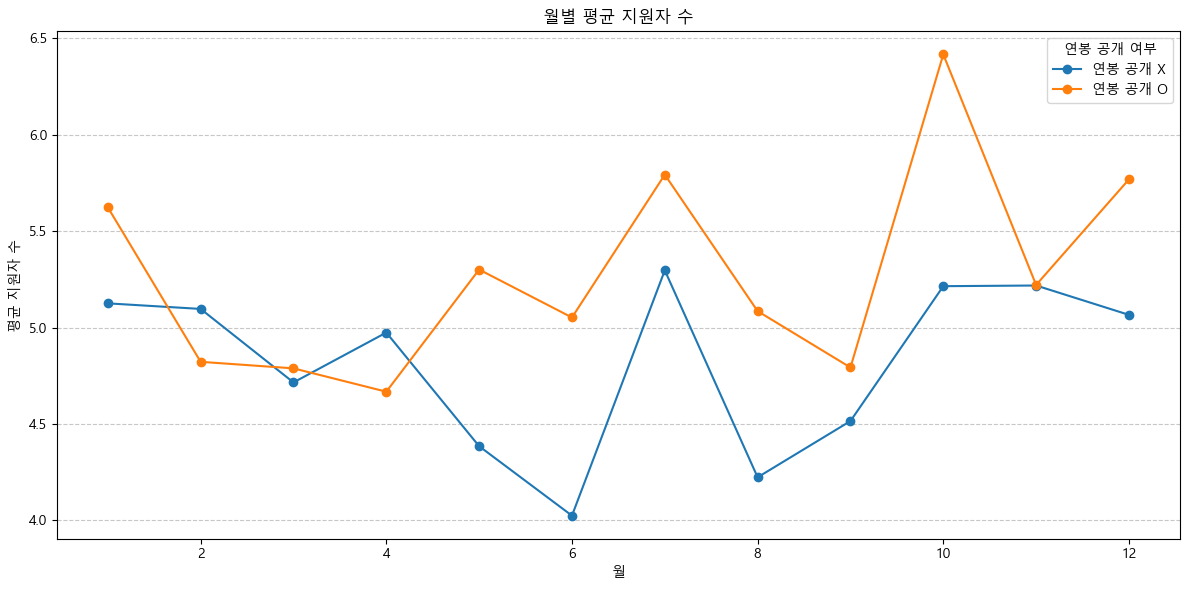

In [ ]:
plt.rc('font', family='Malgun Gothic')

plt.figure(figsize=(12, 6))
salary_pivot_data.plot(ax=plt.gca(), marker='o')
plt.title('월별 평균 지원자 수')
plt.xlabel('월')
plt.ylabel('평균 지원자 수')
plt.legend(title='연봉 공개 여부')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# 연봉 공개 여부와 월별로 그룹화를 하고 지원자 수 평균을 계산.
round_type_grouped_data = result_df.groupby(['can_show_round_type', 'month'])['applicant_count'].mean().reset_index()

# 행을 월, 열을 연봉 공개 여부로한 pivot table 생성.
round_type_pivot_data = round_type_grouped_data.pivot(index='month', columns='can_show_round_type', values='applicant_count')

# 열 이름 변경.
round_type_pivot_data.columns = ['투자 단계 공개 X', '투자 단계 공개 O']

round_type_pivot_data


,투자 단계 공개 X,투자 단계 공개 O
month,,
1,5.055319,5.753903
2,4.747994,5.119167
3,4.562308,4.944095
4,4.793375,4.792774
5,4.275168,5.472841
6,4.370588,4.916918
7,5.578479,5.587997
8,4.553772,4.877128
9,4.542266,4.785767


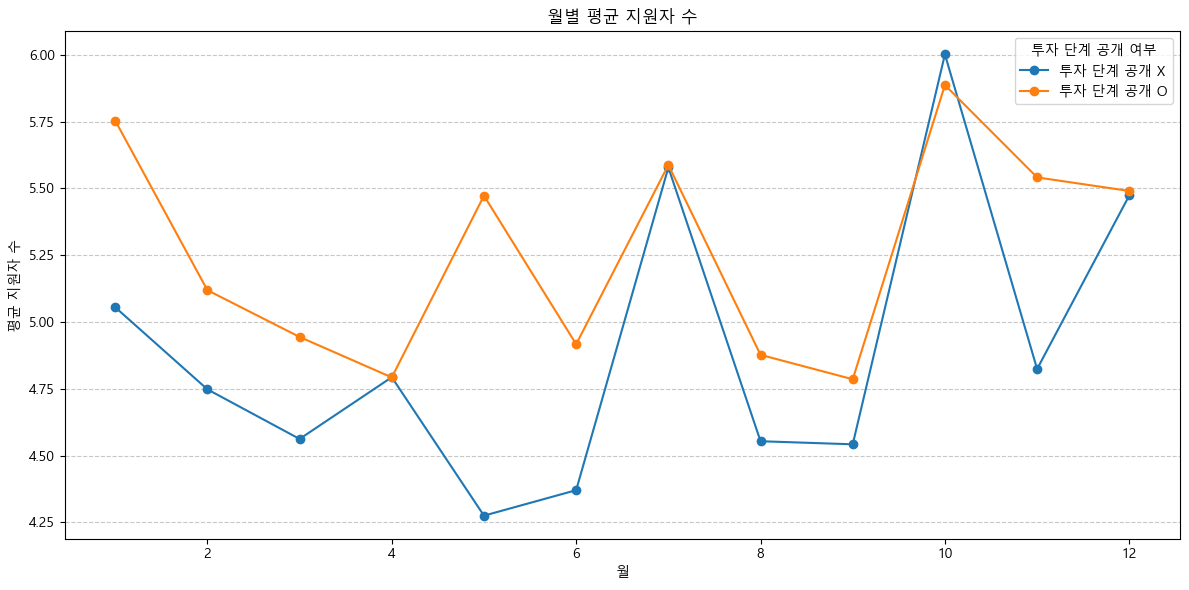

In [ ]:
plt.figure(figsize=(12, 6))
round_type_pivot_data.plot(ax=plt.gca(), marker='o')
plt.title('월별 평균 지원자 수')
plt.xlabel('월')
plt.ylabel('평균 지원자 수')
plt.legend(title='투자 단계 공개 여부')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# 지원자 수 차이.
salary_applicant_diff = (show_salary.mean() - no_show_salary.mean()) / no_show_salary.mean() * 100

round_type_applicant_diff = (show_round_type.mean() - no_show_round_type.mean()) / no_show_round_type.mean() * 100

print(f'연봉 공개를 한 회사의 지원자 수가 하지 않은 회사의 지원자 수보다 {round(salary_applicant_diff, 2)}% 높다.')
print(f'투자 단계 공개를 한 회사의 지원자 수가 하지 않은 회사의 지원자 수보다 {round(round_type_applicant_diff, 2)}% 높다.')

연봉 공개를 한 회사의 지원자 수가 하지 않은 회사의 지원자 수보다 9.2% 높다.
투자 단계 공개를 한 회사의 지원자 수가 하지 않은 회사의 지원자 수보다 7.71% 높다.


## ABtest 기간 설정을 위해 MAU 평균과 conversion rate를 구하고 ABTasty로 계산

In [ ]:
# 데이터 전처리
job_df = job_df.copy()

job_df['start_date'] = pd.to_datetime(job_df['start_date']).dt.date
job_df['end_date'] = pd.to_datetime(job_df['end_date'], errors='coerce').dt.date

# 이상치 제거
today = pd.Timestamp(datetime.today()).date()

job_df = job_df[job_df['start_date'] <= job_df['end_date']]
job_df = job_df[(job_df['end_date'] <= today)]

In [ ]:
job_df

,job_field,career_type_string,start_date,end_date,allow_remote,can_show_salary,job_uuid,company_uuid
0,SW 개발,"신입,경력,인턴",2020-11-25,2020-11-25,1,0,764292b0-53f8-4f14-ac83-6eafc7a6a18d,daa34559-fc42-47f6-b5c6-cc6171404f37
1,HW 개발,인턴,2020-12-03,2020-12-04,1,0,b2b598d6-9ca3-4eb4-ac9c-bb57a6dad2ad,daa34559-fc42-47f6-b5c6-cc6171404f37
2,디자인,"신입,경력,인턴",2019-06-13,2019-06-21,0,0,017f4d7d-91a9-4ef7-9dd7-afabf7cbd26d,d4e7e647-8f85-4e7f-8609-7173cc240e18
3,마케팅,경력,2019-06-14,2019-07-15,0,0,41707ef1-f733-4f58-bb29-0b2e6175cf5e,d4e7e647-8f85-4e7f-8609-7173cc240e18
4,운영,"신입,경력",2019-07-02,2019-08-31,0,0,d0aa0eef-65d2-4e00-8177-968a2dc52009,d4e7e647-8f85-4e7f-8609-7173cc240e18
...,...,...,...,...,...,...,...,...
144240,운영,경력,2019-12-09,2019-12-20,0,1,ab4a46d4-7cec-4275-8ad6-94971e4c4942,f0939862-3174-4b0b-b440-3cdf1e260947
144243,SW 개발,경력,2022-06-07,2022-06-25,1,1,03f1d118-22e3-4659-aa66-565d3e963176,ef64f626-9b9b-46b5-93d8-df575be06ffa
144244,운영,"신입,경력",2023-12-23,2024-01-22,0,1,40308e61-c272-45bc-af2f-0e2e3a29f152,1c74eb98-ad0e-4274-bf91-5a76969b0aa8
144245,운영,"신입,인턴",2023-12-28,2024-01-09,0,1,e4ae1cdb-4ffc-48da-bc91-507b1f97a46f,1c74eb98-ad0e-4274-bf91-5a76969b0aa8


In [ ]:
job_df['start_date'] = pd.to_datetime(job_df['start_date'], errors='coerce')

job_df['Week'] = job_df['start_date'].dt.to_period('W')

# wau 계산: 월별 job uuid의 고윳값 수
wau = job_df.groupby('Week')['job_uuid'].nunique().reset_index()

# 열 이름 변경
wau.columns = ['Week', 'WAU']

wau

,Week,WAU
0,2012-10-01/2012-10-07,1
1,2013-01-07/2013-01-13,1
2,2013-02-04/2013-02-10,1
3,2013-02-18/2013-02-24,1
4,2013-02-25/2013-03-03,2
...,...,...
572,2024-03-11/2024-03-17,2
573,2024-03-18/2024-03-24,3
574,2024-03-25/2024-03-31,2
575,2024-04-01/2024-04-07,1


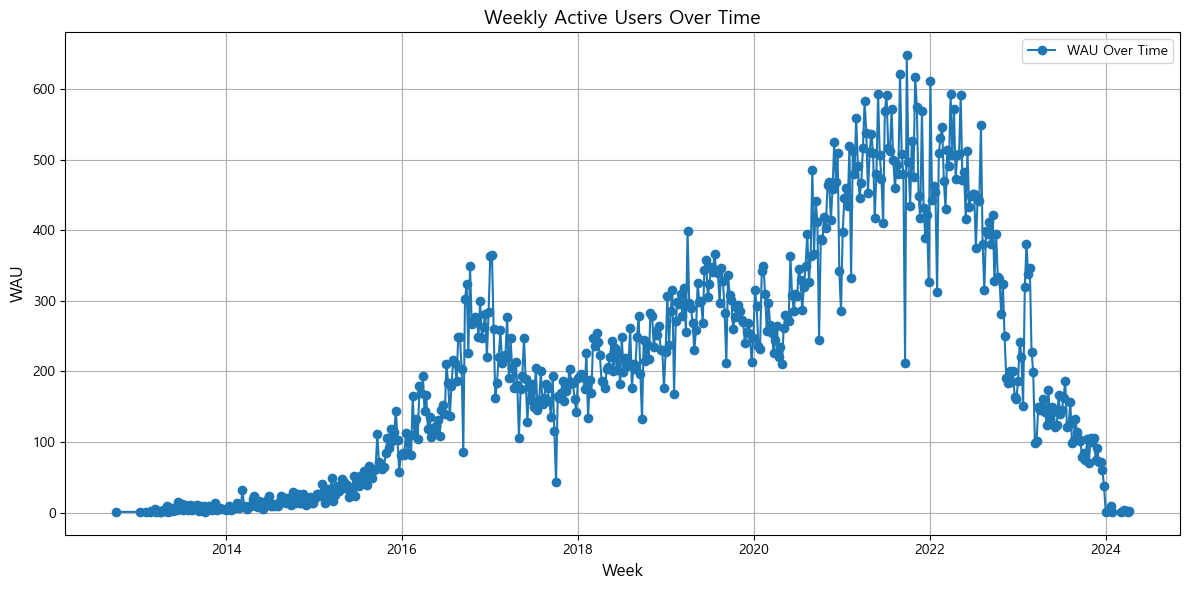

In [ ]:
# 분포 찍어보기
wau['Week'] = wau['Week'].dt.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(wau['Week'], wau['WAU'], marker='o', linestyle='-', label='WAU Over Time')
plt.title('Weekly Active Users Over Time', fontsize=14)
plt.xlabel('Week', fontsize=12)
plt.ylabel('WAU', fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
wau['Week'] = wau['Week'].dt.to_period('W')

In [ ]:
# 채용 공고  등록이 많았던 2020년 6월~2022년 6월 데이터만 추출
filtered_wau_data = wau[(wau['Week'] >= '2020-06') & (wau['Week'] <= '2022-06')]
filtered_wau_data

,Week,WAU
380,2020-06-01/2020-06-07,363
381,2020-06-08/2020-06-14,308
382,2020-06-15/2020-06-21,286
383,2020-06-22/2020-06-28,310
384,2020-06-29/2020-07-05,307
...,...,...
480,2022-05-02/2022-05-08,508
481,2022-05-09/2022-05-15,591
482,2022-05-16/2022-05-22,471
483,2022-05-23/2022-05-29,482


In [ ]:
# WAU 평균
filtered_wau_data['WAU'].mean()

np.float64(457.42857142857144)

In [ ]:
# 전환율
len(job_df[job_df['can_show_salary'] == 1]) / len(job_df)

0.578240546088591

In [ ]:
# DAU 계산: 일별 job uuid의 고윳값 수
dau = job_df.groupby('start_date')['job_uuid'].nunique().reset_index()
dau.columns = ['Year_Month_Day', 'DAU']

dau

,Year_Month_Day,DAU
0,2012-10-01,1
1,2013-01-10,1
2,2013-02-06,1
3,2013-02-18,1
4,2013-02-25,1
...,...,...
3586,2024-03-19,1
3587,2024-03-26,1
3588,2024-03-27,1
3589,2024-04-01,1


In [ ]:
# DAU 계산도 똑같이 2020년 6월~2022년 6월 데이터만 추출
filtered_dau_data = dau[(dau['Year_Month_Day'] >= '2020-06') & (dau['Year_Month_Day'] <= '2022-06')]
filtered_dau_data

,Year_Month_Day,DAU
2293,2020-06-01,110
2294,2020-06-02,65
2295,2020-06-03,84
2296,2020-06-04,49
2297,2020-06-05,47
...,...,...
3018,2022-05-28,10
3019,2022-05-29,9
3020,2022-05-30,122
3021,2022-05-31,67


In [ ]:
# DAU 평균
filtered_dau_data['DAU'].mean()

np.float64(65.53287671232877)

# 📌 로그 및 행동분석, 북마크/공고상세 개선방안 분석

# 📍 로그 분석

## 생키 다이어그램

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
log_df = pd.read_csv('김소연/content/nonq2-log.csv')

In [ ]:
log_df = log_df.dropna()

In [ ]:
# 유저별 시간순 정렬
log_df = log_df.sort_values(by=['user_uuid', 'timestamp'])

In [ ]:
# 직전 이벤트와 다음 이벤트 추가
log_df['pre_event'] = log_df.groupby('user_uuid')['URL'].shift(1)
log_df['next_event'] = log_df.groupby('user_uuid')['URL'].shift(-1)

## 분석 키워드 설정

In [ ]:
# 특정 URL 필터링 함수 선언
def filter_by_keyword(df, keyword):
    return df[df['URL'].str.contains(keyword, na=False)]

In [ ]:
# 필터링할 키워드 설정
search_keyword = ''

In [ ]:
# 필터링된 데이터프레임
filtered_log_df = filter_by_keyword(log_df, search_keyword)

In [ ]:
filtered_log_df.head(3)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,pre_event,next_event
434152,434152,449898,449898,0002535c-eacb-456b-a620-92c917332ba3,@user_id,2022-01-15 07:44:06.150657 UTC,2022-01-15,200,GET,NaN,api/users/id/template
434153,434153,449899,449899,0002535c-eacb-456b-a620-92c917332ba3,api/users/id/template,2022-01-15 07:44:08.578129 UTC,2022-01-15,200,POST,@user_id,@user_id
434199,434199,449945,449945,0002535c-eacb-456b-a620-92c917332ba3,@user_id,2022-03-01 05:45:33.359728 UTC,2022-03-01,200,GET,api/users/id/template,api/users/id/template


## 특정키워드가 포함된 URL 목록 확인


In [ ]:
# 특정키워드가 포함된 URL 목록 확인
keyword_urls = log_df[log_df['URL'].str.contains(search_keyword)]['URL'].unique()

# 결과 출력
print("해당단어가 포함된 URL:")
for url in keyword_urls:
    print(url)

해당단어가 포함된 URL:
@user_id
api/users/id/template
password_reset
continue
jobs/id/apply/step1
api/recommend_specialty
api/users/id/experience/form
api/users/notifications/mark_all_read
api/users/notifications/mark_read
@user_id/job_offer/received
api/jobs/id/apply/step1
jobs/id/apply/step2
api/jobs/id/apply/step2
jobs/id/apply/step3
api/jobs/id/apply/step3
api/job_offer/id/modal
jobs/id/id_title
api/jobs/id/other_jobs
suggest
search
api/search/template
api/users/id/certification/template
jobs/id/apply/step4
api/jobs/id/apply/step4
api/users/id/phone/verify/request
api/users/id/phone/verify
api/users/id/phone/verify/template
api/apply_progress
@user_id/applications
jobs
api/jobs/job_title
companies/company_id/jobs
companies/company_id
api/companies/id/view
api/references
api/users/id/reference/id/form
api/users/id/reference/template
verify_phone
api/timeline
api/users/id/request_button
@user_id/notifications
api/users/notifications
api/users/id/friend_request_modal
api/current_guided_action

## 실행

In [ ]:
# # 특정 기준 URL 필터링
target_url = ''
filtered_url_df = filtered_log_df[filtered_log_df['URL'] == target_url]

In [ ]:
path_df = filtered_url_df[['user_uuid','timestamp','response_code','pre_event','next_event']]

In [ ]:
# filtered_log_df.to_csv('path_df.csv')

In [ ]:
# print(f'타겟 URL: {target_url}')
# print(filtered_url_df['pre_event'].value_counts())
# print(f'==============================\n타겟 URL: {target_url}')
# print(filtered_url_df['next_event'].value_counts())

시각화

In [ ]:
# pre_event 데이터프레임 생성
pre_event_df = path_df['pre_event'].value_counts().reset_index()
pre_event_df.columns = ['source', 'value']
pre_event_df['target'] = target_url

# next_event 데이터프레임 생성
next_event_df = path_df['next_event'].value_counts().reset_index()
next_event_df.columns = ['target', 'value']
next_event_df['source'] = target_url

# pre_event와 next_event 데이터프레임 병합
path_df = pd.concat([pre_event_df, next_event_df])

# 컬럼 이름 변경 (source, value, target 순서로 맞춤)
path_df = path_df[['source', 'target', 'value']]


In [ ]:
# 상위 5개 경로 필터링
top_5_paths = path_df.nlargest(20, 'value')

In [ ]:
import plotly.graph_objects as go
import pandas as pd

# 노드와 링크 데이터 생성
nodes = list(pd.concat([top_5_paths['source'], top_5_paths['target']]).unique())
node_indices = {node: i for i, node in enumerate(nodes)}

source_indices = [node_indices[src] for src in top_5_paths['source']]
target_indices = [node_indices[tgt] for tgt in top_5_paths['target']]
values = top_5_paths['value']

# 링크에 전환율 라벨 추가
labels = [f"{src} → {tgt}: {val:.1f}" for src, tgt, val in zip(top_5_paths['source'], top_5_paths['target'], values)]

# Sankey Diagram 생성
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
        label=labels,
        hovertemplate='%{source.label} → %{target.label}<br>값: %{value}'  # 링크에 표시할 텍스트
    )
))

# 레이아웃 업데이트
fig.update_layout(
    title_text=f"Top 20 Event Paths for {target_url}",
    font_size=12,
    width=800,
    height=600
)

# 그래프 출력
fig.show()


## api/recommend_specialty?

In [ ]:
log_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,pre_event,next_event
434152,434152,449898,449898,0002535c-eacb-456b-a620-92c917332ba3,@user_id,2022-01-15 07:44:06.150657 UTC,2022-01-15,200,GET,NaN,api/users/id/template
434153,434153,449899,449899,0002535c-eacb-456b-a620-92c917332ba3,api/users/id/template,2022-01-15 07:44:08.578129 UTC,2022-01-15,200,POST,@user_id,@user_id
434199,434199,449945,449945,0002535c-eacb-456b-a620-92c917332ba3,@user_id,2022-03-01 05:45:33.359728 UTC,2022-03-01,200,GET,api/users/id/template,api/users/id/template
434185,434185,449931,449931,0002535c-eacb-456b-a620-92c917332ba3,api/users/id/template,2022-03-01 05:45:35.48907 UTC,2022-03-01,200,POST,@user_id,@user_id
434161,434161,449907,449907,0002535c-eacb-456b-a620-92c917332ba3,@user_id,2022-04-18 15:12:10.181361 UTC,2022-04-19,200,GET,api/users/id/template,api/users/id/template
...,...,...,...,...,...,...,...,...,...,...,...
10990469,10990469,1776702,1776702,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/users/id/template,2023-12-18 15:06:35.877009 UTC,2023-12-19,200,POST,@user_id,@user_id
10990447,10990447,1776680,1776680,ffff25ca-c1d7-4fc2-891b-b0df92f95092,@user_id,2023-12-18 15:06:36.763225 UTC,2023-12-19,200,GET,api/users/id/template,api/users/id/template
10990378,10990378,1776610,1776610,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/users/id/template,2023-12-18 15:06:37.210715 UTC,2023-12-19,200,POST,@user_id,jobs
10990367,10990367,1776598,1776598,ffff25ca-c1d7-4fc2-891b-b0df92f95092,jobs,2023-12-18 15:06:46.206558 UTC,2023-12-19,200,GET,api/users/id/template,api/jobs/job_title


In [ ]:
# api/recommend_specialty 관련 데이터 확인
recommend_specialty_details = log_df[log_df['URL'] == 'api/recommend_specialty']
recommend_specialty_details.head(3)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,pre_event,next_event
434133,434133,449879,449879,0002535c-eacb-456b-a620-92c917332ba3,api/recommend_specialty,2022-06-08 06:25:31.800205 UTC,2022-06-08,200,POST,jobs/id/apply/step1,api/users/id/experience/form
434248,434248,449994,449994,0002535c-eacb-456b-a620-92c917332ba3,api/recommend_specialty,2022-06-08 06:25:32.178947 UTC,2022-06-08,200,POST,api/users/id/experience/form,api/users/notifications/mark_all_read
434205,434205,449951,449951,0002535c-eacb-456b-a620-92c917332ba3,api/recommend_specialty,2022-06-11 23:05:46.11213 UTC,2022-06-12,200,POST,jobs/id/apply/step1,api/users/id/experience/form


In [ ]:
# pre_event와 next_event 분포 확인
print("Pre-event 분포:")
print(recommend_specialty_details['pre_event'].value_counts())

print("Next-event 분포:")
print(recommend_specialty_details['next_event'].value_counts())


Pre-event 분포:
pre_event
jobs/id/apply/step1             135315
api/users/id/experience/form    118516
api/recommend_specialty         107586
api/users/id/specialty           79777
api/current_guided_action/id     76426
                                 ...  
api/companies/id/reference           1
pricing/advertising                  1
api/job_offer/id/reject              1
api/jobs/id/share_increase           1
signup/step3/done                    1
Name: count, Length: 175, dtype: int64
Next-event 분포:
next_event
api/jobs/id/apply/step1               116548
api/recommend_specialty               107586
api/search/specialty                   81554
api/users/id/specialty                 73398
api/users/id/template                  61060
                                       ...  
api/users/id/phone/verify/template         1
applications/id/null                       1
@user_id/job_offer                         1
api/companies/id/media                     1
api/comments/modal              

2. api/recommend_specialty의 의문점  
(1) 추천 채용과 관련이 있는가?
- 사용자 설정 단계와 연관 가능성:
Pre-event와 Next-event를 통해 api/recommend_specialty가 사용자 설정(예: 전문성, 경험)과 연결된 이벤트일 가능성이 높다.
특히 signup/step2/career와 같은 이벤트가 이를 뒷받침

- 추천 채용이라 보기 어려운 이유:
추천 채용이라면 특정 채용 공고 ID(job_id)와 연결되어야 하는데, 데이터에서는 공고 ID와의 연결성이 명확하지 않음.
Pre-event와 Next-event에서 "추천된 특정 공고를 클릭하여 이동"하는 흐름이 뚜렷하지 않음.

## 팔로우?

In [ ]:
# 팔로우 후 공고 열람 전환율 분석
follow_to_job_view = log_df[(log_df['pre_event'] == 'api/comapnies/id/follow_button') &
                            (log_df['next_event'].str.contains('job_title'))]

# 전체 팔로우 이벤트 수
total_follows = len(log_df[log_df['pre_event'] == 'api/comapnies/id/follow_button'])

job_view_conversion_rate = (len(follow_to_job_view) / total_follows) * 100
print(f"팔로우 후 공고 열람 전환율: {job_view_conversion_rate:.2f}%")


팔로우 후 공고 열람 전환율: 0.60%


### 팔로우를하고 공고를 보지않는 이유는..??

In [ ]:
# 팔로우 이벤트 이후 행동 흐름
follow_next_events = log_df[log_df['pre_event'] == 'api/comapnies/id/follow_button']['next_event'].value_counts()
print(follow_next_events)


next_event
api/comapnies/id/follow_button    6925
@user_id/following                 401
api/companies/id/bookmark          393
api/companies/id/view              322
jobs/id/id_title                   134
                                  ... 
@user_id/job_offer/sent              1
api/search/specialty                 1
@user_id/blockings                   1
jobs/id/apply/step3                  1
pricing/recruiting                   1
Name: count, Length: 62, dtype: int64


결과를 보면 api/comapnies/id/follow_button 다음에 이어지는 주요 행동은 **또 다른 팔로우 이벤트(46회)**로 나타났다.  
이는 사용자가 한 기업을 팔로우한 후 다른 기업을 연속적으로 팔로우하는 경향이 있음

이 결과는 팔로우 기능이 지원 전환보다는 다른 기업 탐색이나 **네트워크 확장 목적**으로 사용되고 있음을 암시하는 것 같다.

## SNS활동과 채용공고지원

In [ ]:
# SNS 활동 데이터 필터링
sns_activity = log_df[log_df['URL'].str.contains('follow_button|bookmark|timeline|notifications')]

sns_activity


,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,user_uuid,URL,timestamp,date,response_code,method,pre_event,next_event
434277,434277,450023,450023,0002535c-eacb-456b-a620-92c917332ba3,api/users/notifications/mark_all_read,2022-06-08 07:04:00.93602 UTC,2022-06-08,200,GET,api/recommend_specialty,api/users/notifications/mark_read
434260,434260,450006,450006,0002535c-eacb-456b-a620-92c917332ba3,api/users/notifications/mark_read,2022-06-08 07:04:03.490995 UTC,2022-06-08,200,GET,api/users/notifications/mark_all_read,@user_id/job_offer/received
434182,434182,449928,449928,0002535c-eacb-456b-a620-92c917332ba3,api/users/notifications/mark_read,2022-08-01 03:55:30.426145 UTC,2022-08-01,200,GET,api/jobs/job_title,@user_id/job_offer/received
434175,434175,449921,449921,0002535c-eacb-456b-a620-92c917332ba3,api/users/notifications/mark_read,2022-09-12 22:53:56.472278 UTC,2022-09-13,200,GET,@user_id/job_offer/received,@user_id/job_offer/received
434186,434186,449932,449932,0002535c-eacb-456b-a620-92c917332ba3,api/users/notifications/mark_read,2022-09-12 22:54:07.184753 UTC,2022-09-13,200,GET,@user_id/job_offer/received,api/jobs/id/other_jobs
...,...,...,...,...,...,...,...,...,...,...,...
10990840,10990840,1777083,1777083,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/follow_button,2023-02-07 22:28:23.140614 UTC,2023-02-08,200,POST,api/jobs/id/bookmark,jobs/id/id_title
10991107,10991107,1777352,1777352,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/bookmark,2023-02-07 22:32:49.842268 UTC,2023-02-08,200,DELETE,companies/company_id,@user_id/bookmark
10990841,10990841,1777084,1777084,ffff25ca-c1d7-4fc2-891b-b0df92f95092,@user_id/bookmark,2023-02-07 22:32:52.899838 UTC,2023-02-08,200,GET,api/jobs/id/bookmark,jobs
10991126,10991126,1777371,1777371,ffff25ca-c1d7-4fc2-891b-b0df92f95092,api/jobs/id/bookmark,2023-02-07 22:38:26.134881 UTC,2023-02-08,200,PUT,api/recommend_specialty,jobs/id/id_title


In [ ]:
# 유저별 SNS 활동 횟수 계산
sns_activity_counts = sns_activity.groupby('user_uuid').size()
sns_activity_counts

,0
user_uuid,
0002535c-eacb-456b-a620-92c917332ba3,16
000681b4-bb66-4ccf-9786-f0066d13a34e,16
000b55ad-5c86-438b-a5b0-9ea3a2917789,8
000e8610-16d3-4e9e-bf50-202d191ffac4,24
0017a738-4fcc-441e-983b-a6033890a9db,15
...,...
fff082bd-c063-4d10-be2d-b2b53f54527e,3
fff3440e-7c0a-485b-a392-c41023060e96,9
fff45252-3c40-4805-99e9-6b650c1fca80,8


In [ ]:
# 유저별 지원 활동 횟수 계산
application_activity = log_df[log_df['URL'].str.contains('jobs/id/apply/step1')]
application_counts = application_activity.groupby('user_uuid').size()

In [ ]:
# SNS 활동과 지원 활동 데이터 병합
activity_df = pd.DataFrame({
    'sns_activity_count': sns_activity_counts,
    'application_count': application_counts
}).fillna(0)

In [ ]:
# SNS 활동 많은 유저와 지원 활동 간의 상관성 분석
correlation = activity_df['sns_activity_count'].corr(activity_df['application_count'])
print(f"SNS 활동과 지원 활동 간 상관계수: {correlation:.2f}")


SNS 활동과 지원 활동 간 상관계수: 0.07


In [ ]:
activity_df.describe()

,sns_activity_count,application_count
count,18254.000000,18254.000000
mean,31.394051,8.156240
std,290.838866,27.745127
min,0.000000,0.000000
25%,4.000000,0.000000
50%,11.000000,2.000000
75%,29.000000,8.000000
max,37599.000000,1027.000000


In [ ]:
# SNS 사용 비율 계산 (SNS 활동 횟수 / (SNS 활동 + 지원 활동))
activity_df['activity_ratio'] = activity_df['sns_activity_count'] / (activity_df['application_count'] + 1)

# SNS 활동 비율 기준으로 유저 분류 (비율이 3 이상인 유저는 SNS 활동 중심)
activity_df['user_type'] = activity_df['activity_ratio'] > 3  # 비율이 3 초과인 유저는 SNS 중심으로 분류

# SNS 활동 중심 유저 비율
sns_users_ratio = activity_df['user_type'].mean() * 100
print(f"SNS 활동 중심 유저 비율: {sns_users_ratio:.2f}%")

# 각 그룹의 평균 활동 데이터 확인
print("\nSNS 활동 중심 유저 평균 활동:")
print(activity_df[activity_df['user_type'] == True].mean())

print("\n단순히 보는 유저 평균 활동:")
print(activity_df[activity_df['user_type'] == False].mean())


SNS 활동 중심 유저 비율: 47.73%

SNS 활동 중심 유저 평균 활동:
sns_activity_count    50.927571
application_count      3.911042
activity_ratio        16.834372
user_type              1.000000
dtype: float64

단순히 보는 유저 평균 활동:
sns_activity_count    13.559631
application_count     12.032174
activity_ratio         1.402177
user_type              0.000000
dtype: float64


In [ ]:
from scipy import stats

# SNS 활동 상위 30%와 하위 30%로 나누기
top_30_sns_users = activity_df[activity_df['sns_activity_count'] >= activity_df['sns_activity_count'].quantile(0.7)]
bottom_30_sns_users = activity_df[activity_df['sns_activity_count'] <= activity_df['sns_activity_count'].quantile(0.3)]

# NaN 및 0 값을 제외한 지원 활동 횟수
top_30_sns_users_clean = top_30_sns_users[top_30_sns_users['application_count'] > 0]['application_count']
bottom_30_sns_users_clean = bottom_30_sns_users[bottom_30_sns_users['application_count'] > 0]['application_count']

# t-검정 수행
t_stat, p_value = stats.ttest_ind(top_30_sns_users_clean, bottom_30_sns_users_clean)

# 결과 출력
print(f"t-검정 통계량: {t_stat:.2f}")
print(f"p-value: {p_value:.5f}")


t-검정 통계량: 15.29
p-value: 0.00000


In [ ]:
# SNS 중심 유저의 로그 데이터 추출
sns_users = activity_df[activity_df['user_type'] == True].index
sns_user_logs = log_df[log_df['user_uuid'].isin(sns_users)]

# 주요 행동 경로 확인
sns_user_paths = sns_user_logs.groupby(['pre_event', 'next_event']).size().reset_index(name='count')
print(sns_user_paths.sort_values(by='count', ascending=False).head(10))


                               pre_event                         next_event  \
6022                  api/jobs/job_title                 api/jobs/job_title   
19548                            suggest                            suggest   
14350              api/users/id/template              api/users/id/template   
17936                   jobs/id/id_title                   jobs/id/id_title   
0                               @user_id                           @user_id   
158                             @user_id              api/users/id/template   
5599              api/jobs/id/other_jobs             api/jobs/id/other_jobs   
6017                  api/jobs/job_title             api/jobs/id/other_jobs   
2627   api/companies/id/ad_stat/progress  api/companies/id/ad_stat/progress   
5719              api/jobs/id/other_jobs                   jobs/id/id_title   

        count  
6022   260362  
19548  196185  
14350  190304  
17936  188941  
0      170088  
158    165150  
5599   161092  
60

In [ ]:
# 지원 중심 유저의 로그 데이터 추출
sns_users = activity_df[activity_df['user_type'] == False].index
sns_user_logs = log_df[log_df['user_uuid'].isin(sns_users)]

# 주요 행동 경로 확인
sns_user_paths = sns_user_logs.groupby(['pre_event', 'next_event']).size().reset_index(name='count')
print(sns_user_paths.sort_values(by='count', ascending=False).head(10))


                     pre_event                    next_event   count
4690        api/jobs/job_title            api/jobs/job_title  186822
14877         jobs/id/id_title              jobs/id/id_title  169077
4344    api/jobs/id/other_jobs        api/jobs/id/other_jobs  144348
4687        api/jobs/job_title        api/jobs/id/other_jobs  111311
16252                  suggest                       suggest  107941
4454    api/jobs/id/other_jobs              jobs/id/id_title   88036
4794        api/jobs/job_title              jobs/id/id_title   84814
3764   api/jobs/id/apply/step1  api/users/id/experience/form   81989
5706   api/recommend_specialty           jobs/id/apply/step2   81969
269      @user_id/applications         @user_id/applications   81795


In [ ]:
sns_data = log_df[log_df['URL'].isin(sns_urls)]

NameError: name 'sns_urls' is not defined

In [ ]:
# SNS 관련 URL만 필터링
sns_data_filtered = log_df[log_df['URL'].isin(sns_urls)]

# SNS 활동 횟수 계산 (SNS 관련 URL만 고려)
sns_activity_counts = sns_data_filtered.groupby('user_uuid')['URL'].count().rename('sns_activity_count')

# Step 1에 도달한 사용자별 횟수 계산
step1_counts = log_df[log_df['URL'] == 'api/jobs/id/apply/step1']['user_uuid'].value_counts()
step1_counts.name = 'apply_step1_count'

# SNS 활동 데이터와 Step 1 데이터 병합
correlation_data = pd.concat([sns_activity_counts, step1_counts], axis=1).fillna(0)

# 결과 출력
print(correlation_data.head())


In [ ]:
correlation = correlation_data.corr()
print(correlation)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Between SNS Activity and Step 1 Completion") # SNS 활동과 step1 도달 간 상관관계
plt.show()


회귀분석

In [ ]:
import statsmodels.api as sm

# 데이터 준비
X = correlation_data['sns_activity_count']
y = correlation_data['apply_step1_count']

# 상수항 추가
X = sm.add_constant(X)

# 회귀 모델 학습
model = sm.OLS(y, X).fit()

# 결과 출력
print(model.summary())


In [ ]:
#  URL별로 개별 상관계수 계산

In [ ]:
# URL별 활동 횟수 계산
url_counts = log_df.groupby(['user_uuid', 'URL']).size().unstack(fill_value=0)

# Step 1 도달 횟수 추가
url_counts['apply_step1_count'] = log_df[log_df['URL'] == 'api/jobs/id/apply/step1'].groupby('user_uuid').size()

# 상관계수 계산 (열 간 상관관계)
correlation_matrix = url_counts.corr()

# 결과 출력
print(correlation_matrix['apply_step1_count'].sort_values(ascending=False))


# 📍 기업 정보 분석

## 팔로워, 조회수별 지원자수 분석

In [ ]:
import pandas as pd

### 1. 데이터 불러오기

In [ ]:
application_df = pd.read_csv('Application.csv')

In [ ]:
merged_company_data = pd.read_csv('merged_company_data.csv')

### 2. 데이터 병합 (company_uuid 기준)

In [ ]:
merged_df = pd.merge(application_df, merged_company_data, on='company_uuid', how='left')

In [ ]:
merged_df.head()

,Unnamed: 0_x,cdate_x,company_uuid,job_uuid,user_uuid,application_uuid,Unnamed: 0_y,cdate_y,mdate,found_date,employee_count,view_count,follow_count,reference_count,name,address,fund_date,round_type,raised
0,0,2017-02-25 23:45:01,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,b0329bd7-fc45-4e83-993a-b73bd9d3549c,59c42363-f764-4cbd-aafd-20eb663ea5d7,49644.0,2013-01-10 15:47:37,2024-04-30 06:58:23,2013-01-04,11-50명,575596.0,2740.0,142.0,알리콘 왕십리 오피스,서울특별시 성동구,2015-11-11,Seed,7.857143e+04
1,0,2017-02-25 23:45:01,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,b0329bd7-fc45-4e83-993a-b73bd9d3549c,59c42363-f764-4cbd-aafd-20eb663ea5d7,49645.0,2013-01-10 15:47:37,2024-04-30 06:58:23,2013-01-04,11-50명,575596.0,2740.0,142.0,알리콘 왕십리 오피스,서울특별시 성동구,2018-04-09,Series A,7.142857e+05
2,0,2017-02-25 23:45:01,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,b0329bd7-fc45-4e83-993a-b73bd9d3549c,59c42363-f764-4cbd-aafd-20eb663ea5d7,49646.0,2013-01-10 15:47:37,2024-04-30 06:58:23,2013-01-04,11-50명,575596.0,2740.0,142.0,알리콘 왕십리 오피스,서울특별시 성동구,2021-10-31,Series B,5.857143e+06
3,0,2017-02-25 23:45:01,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,b0329bd7-fc45-4e83-993a-b73bd9d3549c,59c42363-f764-4cbd-aafd-20eb663ea5d7,49647.0,2013-01-10 15:47:37,2024-04-30 06:58:23,2013-01-04,11-50명,575596.0,2740.0,142.0,알리콘 왕십리 오피스,서울특별시 성동구,2016-10-13,투자 단계 비공개,1.428571e+05
4,0,2017-02-25 23:45:01,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37,b0329bd7-fc45-4e83-993a-b73bd9d3549c,59c42363-f764-4cbd-aafd-20eb663ea5d7,49648.0,2013-01-10 15:47:37,2024-04-30 06:58:23,2013-01-04,11-50명,575596.0,2740.0,142.0,알리콘 정동 집무실,서울특별시 중구,2015-11-11,Seed,7.857143e+04


### 3. 결측치 확인

In [ ]:
merged_df.isna().sum()

Unnamed: 0_x             0
cdate_x                  0
company_uuid             0
job_uuid                 0
user_uuid                0
application_uuid         0
Unnamed: 0_y         21013
cdate_y              21013
mdate                21013
found_date           40585
employee_count       21013
view_count           21013
follow_count         21013
reference_count      21013
name                 37477
address              37363
fund_date           195948
round_type          195948
raised              195948
dtype: int64

### 4. 기업 규모 분류 함수 정의

In [ ]:
merged_df['employee_count'].value_counts().head()

employee_count
11-50명      443921
0명          264348
51-200명     258419
1-10명       128862
201-500명     73792
Name: count, dtype: int64

In [ ]:
def classify_company(employee_count):
    if employee_count in ['501-1000명', '1000명 이상']:
        return '대기업'
    else:
        return '중소기업'

### 5. 대기업/중소기업 컬럼 추가

In [ ]:
merged_df['company_size'] = merged_df['employee_count'].apply(classify_company)

### 6. 대기업 vs 중소기업 지원 수 비교

In [ ]:
company_size_comparison = merged_df['company_size'].value_counts()
company_size_comparison

company_size
중소기업    1202586
대기업        6302
Name: count, dtype: int64

In [ ]:
merged_df['address'].value_counts()

address
서울특별시 강남구                                   410261
서울특별시 서초구                                   149735
서울특별시 마포구                                    92744
서울특별시 성동구                                    73064
서울특별시 중구                                     49510
                                             ...  
독일 노르트라인 베스트팔렌                                   1
독일                                               1
충청북도 단양군                                         1
2 Changi Business Park Cres, 싱가포르 486029         1
Heinestraße 21, 1020 Wien, 오스트리아                 1
Name: count, Length: 352, dtype: int64

### 7. 회사별 지원 수 집계

In [ ]:
company_application_counts = merged_df[['company_uuid', 'address', 'company_size', 'view_count', 'follow_count','reference_count', 'raised','round_type']]

In [ ]:
# 회사별 지원 수 확인
company_application_counts = company_application_counts.value_counts().reset_index(name='application_count')

company_application_counts


,company_uuid,address,company_size,view_count,follow_count,reference_count,raised,round_type,application_count
0,f6156b12-d4d7-469f-84be-31799c765211,서울특별시 마포구,중소기업,67636.0,1651.0,83.0,0.000000e+00,Series A,5904
1,47990a4b-3d21-431b-a465-cecbc4b67de3,서울특별시 강남구,중소기업,24782.0,657.0,33.0,1.428571e+07,투자 단계 비공개,5863
2,47990a4b-3d21-431b-a465-cecbc4b67de3,서울특별시 강남구,중소기업,24782.0,657.0,33.0,2.142857e+06,투자 단계 비공개,5863
3,47990a4b-3d21-431b-a465-cecbc4b67de3,서울특별시 강남구,중소기업,24782.0,657.0,33.0,8.571429e+06,투자 단계 비공개,5863
4,47990a4b-3d21-431b-a465-cecbc4b67de3,서울특별시 강남구,중소기업,24782.0,657.0,33.0,2.785714e+07,투자 단계 비공개,5863
...,...,...,...,...,...,...,...,...,...
6705,01bcb0c3-5b2d-4d54-bf1c-da5c4aa6dc01,서울특별시 서초구,중소기업,6692.0,13.0,1.0,2.142857e+06,Series A,1
6706,824da18d-4b20-4cea-9ed2-c57064109ec4,서울특별시 마포구,중소기업,3577.0,8.0,4.0,1.714286e+04,Angel,1
6707,824da18d-4b20-4cea-9ed2-c57064109ec4,서울특별시 강남구,중소기업,3577.0,8.0,4.0,1.071429e+05,Seed,1
6708,824da18d-4b20-4cea-9ed2-c57064109ec4,서울특별시 강남구,중소기업,3577.0,8.0,4.0,1.714286e+04,Angel,1


### 8. 숫자형 데이터 상관계수 분석

In [ ]:
# 숫자형 데이터만 선택
numeric_columns = company_application_counts.select_dtypes(include=['float64', 'int64'])

# 상관계수 계산
correlation_matrix = numeric_columns.corr()


correlation_matrix

,view_count,follow_count,reference_count,raised,application_count
view_count,1.000000,0.577887,0.500995,0.061696,0.274682
follow_count,0.577887,1.000000,0.875257,0.044292,0.729099
reference_count,0.500995,0.875257,1.000000,0.033950,0.589169
raised,0.061696,0.044292,0.033950,1.000000,0.021956
application_count,0.274682,0.729099,0.589169,0.021956,1.000000


<Axes: >

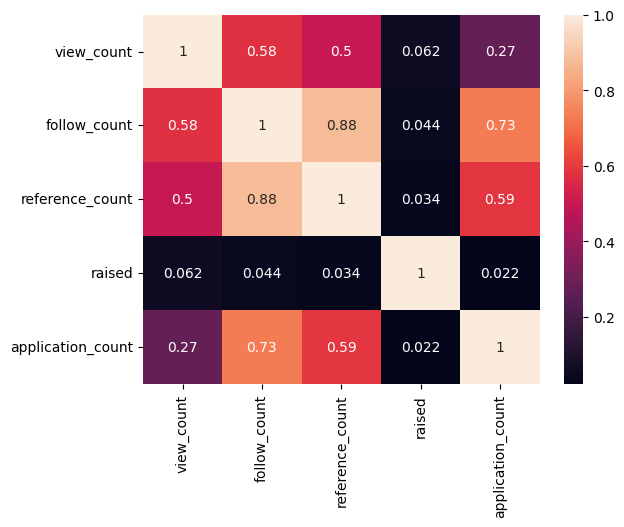

In [ ]:
import seaborn as sns
sns.heatmap(correlation_matrix,annot=True)

### 상관계수 히트맵 시각화

팔로잉하는 기업이나 추천기업에 지원을 많이하는군

### 9. 회귀 분석 - 숫자형 데이터만 사용

In [ ]:
import pandas as pd
import statsmodels.api as sm


# 독립 변수(X)와 종속 변수(y) 설정
X = numeric_columns.drop('application_count', axis=1)
y = numeric_columns['application_count']

# 상수항 추가
X = sm.add_constant(X)

# 회귀 모델 생성 및 적합
model = sm.OLS(y, X).fit()

# 회귀 결과 출력
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      application_count   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.574
Method:                 Least Squares   F-statistic:                     2264.
Date:                Wed, 08 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:17:23   Log-Likelihood:                -46348.
No. Observations:                6710   AIC:                         9.271e+04
Df Residuals:                    6705   BIC:                         9.274e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              24.7654      3.476     

## 기업 상세정보 등록별 지원량 분석

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
company_df = pd.read_csv('merged_company_data.csv')
application_df = pd.read_csv('merged_application_data.csv')

In [ ]:
application_df.duplicated().sum()

np.int64(0)

In [ ]:
# 중복 제거 및 필요한 열 선택
application_count = application_df[['company_uuid', 'job_uuid']].drop_duplicates()
application_count

,company_uuid,job_uuid
0,de4b3596-b4ab-47cd-b8ea-6f9e14170064,459e461d-a571-4ed3-8751-8f4cb5b9ff37
8,f6156b12-d4d7-469f-84be-31799c765211,e5ed4f4a-08aa-4f2d-9042-1e9bbd36803f
23,2ed05b18-c735-474a-9faa-02095b25729a,0f636d7a-53f7-485e-8a08-33253ddab380
29,3d6730ee-b869-47b7-90c6-1e074e4eb15b,3cade56a-6354-411a-82a6-f2c7774539c1
38,9a05a18c-9902-4a61-9aa8-91953a661f17,5159d551-0085-4a61-b2ee-fc672ef636d9
...,...,...
1143241,3ae9cbdd-311d-4938-9426-e4218d70a87e,38e6780d-77c0-4656-b300-bb835fe8ad1d
1143250,3ae9cbdd-311d-4938-9426-e4218d70a87e,b218b939-3f6a-403b-8b65-56df8eaa5117
1143266,83a9b52a-dfaa-439a-9df4-9f2b74d0619d,911ddf9d-8091-4583-a7ab-cf5afac06404
1143268,93ca871f-cdf5-4211-b438-8ee5e63aca48,1a1e7f71-d067-4868-bf1e-5ae16a0916bf


In [ ]:
application_count= application_count.groupby('company_uuid').size().reset_index(name='application_count')

In [ ]:
# 병합
merged_df = pd.merge(company_df, application_count, on='company_uuid', how='left')

In [ ]:
merged_df.columns

Index(['Unnamed: 0', 'cdate', 'mdate', 'found_date', 'employee_count',
       'view_count', 'follow_count', 'reference_count', 'company_uuid', 'name',
       'address', 'fund_date', 'round_type', 'raised', 'application_count'],
      dtype='object')

In [ ]:
# 상세정보 열 목록
info_columns = ['found_date', 'name', 'address', 'fund_date', 'round_type', 'raised']

# 상세정보 등록률 계산 (null 값이 아닌 열의 비율 * 100)
merged_df['info_completion_rate'] = merged_df[info_columns].notnull().mean(axis=1) * 100

# 결과 확인
print(merged_df[['company_uuid', 'info_completion_rate']].head())


                           company_uuid  info_completion_rate
0  725e87bb-de2f-416a-a6b8-1ca8d0d096e0              0.000000
1  efa3747d-9bbd-4c84-af51-82ccf6545dcd              0.000000
2  84aa2c20-d0f3-4ec3-ac06-1ef67e071b8f              0.000000
3  761e76b3-507c-4c8f-b96f-fa47a8ccb5f2             16.666667
4  966a7fb0-96ad-410b-905e-f10446807f1e              0.000000


In [ ]:
# 1. application_count의 NaN 값을 0으로 대체
merged_df['application_count'] = merged_df['application_count'].fillna(0)

# 2. view_count의 NaN 및 0 값을 1로 대체
merged_df['view_count'] = merged_df['view_count'].replace(0, 1).fillna(1)

# 3. 지원률 계산
merged_df['apply_rate'] = (merged_df['application_count'] / merged_df['view_count']) * 100

# 4. 결과 확인
print(merged_df[['company_uuid', 'info_completion_rate', 'apply_rate']].head())


                           company_uuid  info_completion_rate  apply_rate
0  725e87bb-de2f-416a-a6b8-1ca8d0d096e0              0.000000         0.0
1  efa3747d-9bbd-4c84-af51-82ccf6545dcd              0.000000         0.0
2  84aa2c20-d0f3-4ec3-ac06-1ef67e071b8f              0.000000         0.0
3  761e76b3-507c-4c8f-b96f-fa47a8ccb5f2             16.666667         0.0
4  966a7fb0-96ad-410b-905e-f10446807f1e              0.000000         0.0


In [ ]:
# 상관관계 분석
correlation = merged_df[['info_completion_rate', 'apply_rate']].corr()
print("상세정보 등록률과 지원률 간의 상관관계:")
print(correlation)

상세정보 등록률과 지원률 간의 상관관계:
                      info_completion_rate  apply_rate
info_completion_rate              1.000000    0.365331
apply_rate                        0.365331    1.000000


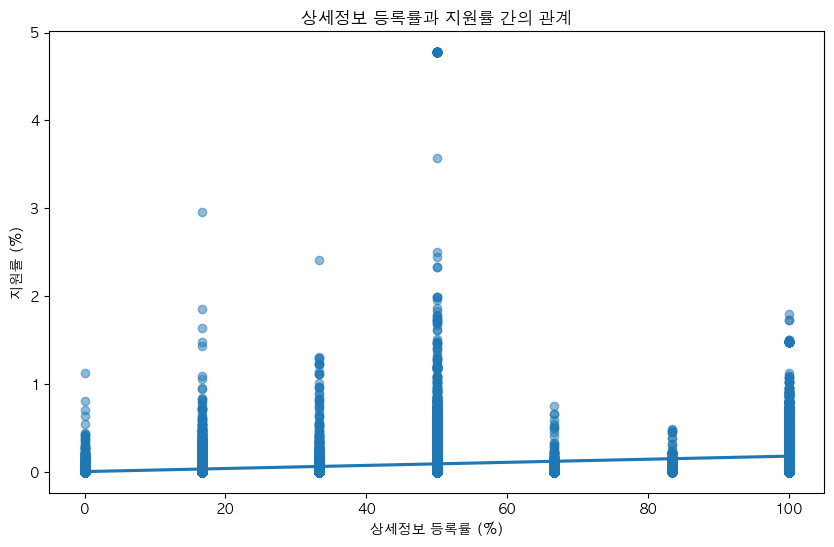

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='AppleGothic'
# 산점도 그래프 + 경향선 추가 + 투명도 조정
plt.figure(figsize=(10, 6))
sns.regplot(data=merged_df, x='info_completion_rate', y='apply_rate', scatter_kws={'alpha': 0.5})
plt.title('상세정보 등록률과 지원률 간의 관계')
plt.xlabel('상세정보 등록률 (%)')
plt.ylabel('지원률 (%)')
plt.show()


In [ ]:
# 'found_date', 'address', 'name'의 결측값 수 계산
company_df['missing_values'] = company_df[['found_date', 'address', 'name']].isnull().sum(axis=1)

# 결측값 수 별로 그룹화하고 'view_count', 'follow_count', 'reference_count' 평균 계산
missing_value_analysis = company_df.groupby('missing_values')[['view_count', 'follow_count', 'reference_count']].mean()

# 결과 출력
print(missing_value_analysis)

                 view_count  follow_count  reference_count
missing_values                                            
0               7337.554789     77.331255         4.917418
1               4034.310615     26.468156         1.455866
2               1501.402566      3.440167         0.398538
3                506.201386      0.403111         0.060691


회수(view_count), 팔로워수(follow_count), 추천수(reference_count)가 **지원량(application_count)**과 관계가 있는지 상관관계를 분석하고, 시각화를 통해 확인

✅ 분석 단계
조회수, 팔로워수, 추천수와 지원량 간의 상관계수 확인
산점도 그래프 시각화 (각 변수와 지원량 간의 관계)
해석 및 인사이트 도출

상관관계 분석 결과:
                   view_count  follow_count  reference_count  \
view_count           1.000000      0.612197         0.588152   
follow_count         0.612197      1.000000         0.891114   
reference_count      0.588152      0.891114         1.000000   
application_count    0.472902      0.760569         0.704058   

                   application_count  
view_count                  0.472902  
follow_count                0.760569  
reference_count             0.704058  
application_count           1.000000  


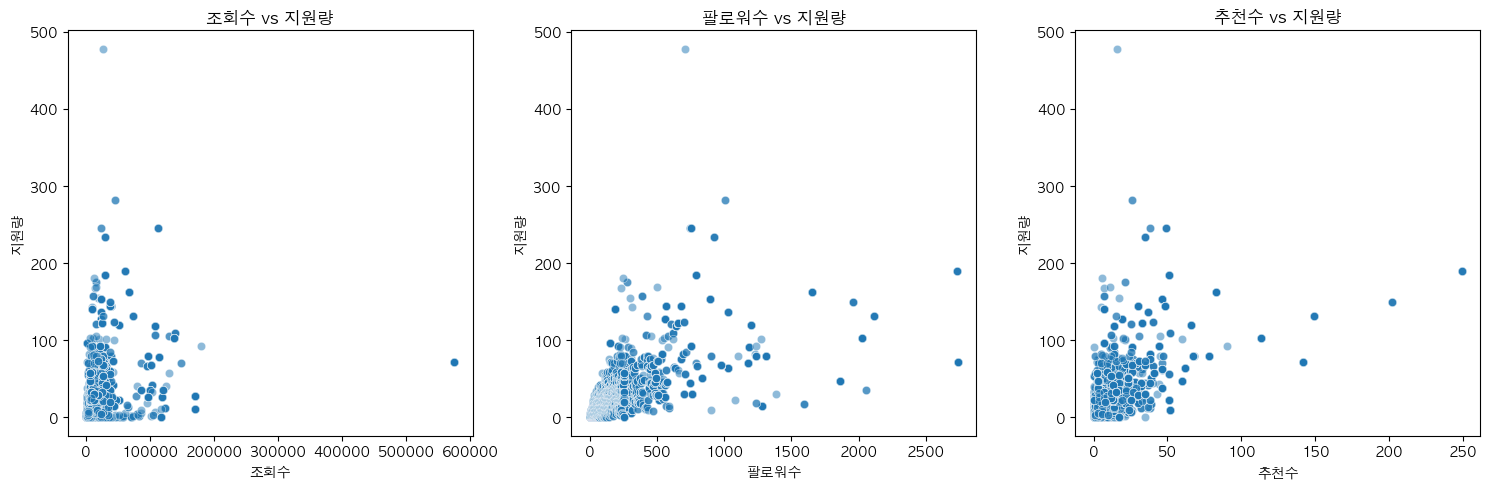

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 상관관계 분석
correlation = merged_df[['view_count', 'follow_count', 'reference_count', 'application_count']].corr()
print("상관관계 분석 결과:")
print(correlation)

# 2. 산점도 그래프 시각화
plt.figure(figsize=(15, 5))

# 조회수 vs 지원량
plt.subplot(1, 3, 1)
sns.scatterplot(data=merged_df, x='view_count', y='application_count', alpha=0.5)
plt.title('조회수 vs 지원량')
plt.xlabel('조회수')
plt.ylabel('지원량')

# 팔로워수 vs 지원량
plt.subplot(1, 3, 2)
sns.scatterplot(data=merged_df, x='follow_count', y='application_count', alpha=0.5)
plt.title('팔로워수 vs 지원량')
plt.xlabel('팔로워수')
plt.ylabel('지원량')

# 추천수 vs 지원량
plt.subplot(1, 3, 3)
sns.scatterplot(data=merged_df, x='reference_count', y='application_count', alpha=0.5)
plt.title('추천수 vs 지원량')
plt.xlabel('추천수')
plt.ylabel('지원량')

# 그래프 출력
plt.tight_layout()
plt.show()


📊 그래프 해석
1. 조회수 vs 지원량
조회수가 증가할수록 지원량도 증가하는 경향이 보입니다.  
하지만 대부분의 데이터가 조회수 10만 이하, 지원량 100건 이하에 몰려 있으며, 일부 기업만 조회수가 매우 높습니다.  
극단적으로 조회수가 높은 일부 기업이 있지만, 지원량이 그에 비례하지는 않는 경우도 있습니다.  

2. 팔로워수 vs 지원량  
팔로워수가 증가할수록 지원량이 약간 증가하는 경향이 보입니다.  
하지만 데이터가 팔로워수 500 이하에 집중되어 있으며, 일부 기업만 팔로워수가 높습니다.  
팔로워수가 높은 기업이 반드시 지원량이 많지는 않음을 알 수 있습니다.  

3. 추천수 vs 지원량
추천수가 증가할수록 지원량이 증가하는 경향이 보입니다.  
다만, 대부분의 기업이 추천수 50 이하에 몰려 있습니다.  
추천수가 높은 기업의 지원량이 상대적으로 많음을 알 수 있지만, 데이터가 편중되어 있습니다.

## **연봉공개 및 투자단계가 공개된 채용공고의 평균 북마크수 T-TEST 분석**



In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
job_df = pd.read_csv('Cleaned_Job.csv')
job_bookmark_df = pd.read_csv('Cleaned_JobBookmark.csv')
company_fund_df = pd.read_csv('Cleaned_Companyfund.csv')

In [ ]:
# 채용공고별 북마크 수 계산
job_bookmark_counts = job_bookmark_df.groupby('job_uuid'). size().reset_index(name='bookmark_count')

In [ ]:
# 채용 데이터에 북마크 수 데이터 병합
job_merged = job_df.merge(job_bookmark_counts, on='job_uuid', how='left')
job_merged.head(3)

,cdate,mdate,job_field,career_type_string,start_date,end_date,allow_remote,can_show_salary,job_uuid,company_uuid,bookmark_count
0,2020-11-25 10:32,2020-11-25 10:32,SW 개발,"신입,경력,인턴",2020-11-25,2020-11-25,1,0,764292b0-53f8-4f14-ac83-6eafc7a6a18d,daa34559-fc42-47f6-b5c6-cc6171404f37,NaN
1,2020-12-03 16:24,2020-12-03 16:24,HW 개발,인턴,2020-12-03,2020-12-04,1,0,b2b598d6-9ca3-4eb4-ac9c-bb57a6dad2ad,daa34559-fc42-47f6-b5c6-cc6171404f37,NaN
2,2019-06-13 8:47,2019-06-13 8:47,디자인,"신입,경력,인턴",2019-06-13,2019-06-21,0,0,017f4d7d-91a9-4ef7-9dd7-afabf7cbd26d,d4e7e647-8f85-4e7f-8609-7173cc240e18,NaN


In [ ]:
# 북마크 수 NaN 값을 0으로 대체 (북마크가 없는 공고 처리)
job_merged['bookmark_count'] = job_merged['bookmark_count'].fillna(0)

In [ ]:
company_fund_df['round_type'].unique()

array(['Seed', 'Angel', '투자 단계 비공개', 'Series A', '해당없음', 'Series B',
       'Series C', 'Series D', 'Pre-IPO'], dtype=object)

In [ ]:
# 회사 펀딩 데이터와 병합하여 투자 단계 공개 여부 추가
company_fund_df['fund_visibility'] = company_fund_df['round_type'].apply(lambda x: 0 if x == '투자 단계 비공개' else 1)

In [ ]:
fund_visibility_map = company_fund_df[['company_uuid','fund_visibility']]
fund_visibility_map.head(3)

,company_uuid,fund_visibility
0,2bf21122-15b6-4e6e-ae32-6e25968246f6,1
1,2bf21122-15b6-4e6e-ae32-6e25968246f6,1
2,2bf21122-15b6-4e6e-ae32-6e25968246f6,1


In [ ]:
# 병합
job_merged = job_merged.merge(fund_visibility_map, on='company_uuid', how='left')
job_merged.head(3)

,cdate,mdate,job_field,career_type_string,start_date,end_date,allow_remote,can_show_salary,job_uuid,company_uuid,bookmark_count,fund_visibility
0,2020-11-25 10:32,2020-11-25 10:32,SW 개발,"신입,경력,인턴",2020-11-25,2020-11-25,1,0,764292b0-53f8-4f14-ac83-6eafc7a6a18d,daa34559-fc42-47f6-b5c6-cc6171404f37,0.0,NaN
1,2020-12-03 16:24,2020-12-03 16:24,HW 개발,인턴,2020-12-03,2020-12-04,1,0,b2b598d6-9ca3-4eb4-ac9c-bb57a6dad2ad,daa34559-fc42-47f6-b5c6-cc6171404f37,0.0,NaN
2,2019-06-13 8:47,2019-06-13 8:47,디자인,"신입,경력,인턴",2019-06-13,2019-06-21,0,0,017f4d7d-91a9-4ef7-9dd7-afabf7cbd26d,d4e7e647-8f85-4e7f-8609-7173cc240e18,0.0,NaN


In [ ]:
# fund_visibility의 NaN 값을 0으로
job_merged['fund_visibility'] = job_merged['fund_visibility'].fillna(0).astype(int)

In [ ]:
# 연봉 공개 여부와 투자 단계 공개 여부에 따른 그룹 나누기
group1 = job_merged[(job_merged['can_show_salary'] == 1) & (job_merged['fund_visibility'] == 1)]['bookmark_count']
group2 = job_merged[(job_merged['can_show_salary'] == 0) | (job_merged['fund_visibility'] == 0)]['bookmark_count']

### **F-검정 (등분산성 테스트)**

귀무가설 : 두 그룹의 분산이 서로 같다.  
대립가설 : 두 그룹의 분산이 서로 다르다.

In [ ]:
from scipy.stats import ttest_ind, levene

In [ ]:
f_stat, f_p_value = levene(group1, group2)

In [ ]:
print(f"F-statistic: {f_stat}")
print(f"F-test P-value: {f_p_value}")

F-statistic: 173.41574931649592
F-test P-value: 1.372224607881642e-39


P-value가 매우 낮아 (0.05보다 작음)   
두 그룹의 분산이 같지 않다는 귀무가설을 기각  
따라서 T-테스트에서 **equal_var=False**를 설정하는 것이 적합

### **t-test 수행**

귀무가설:
연봉과 투자 단계 공개 여부에 따라 채용 공고의 평균 북마크 수에 차이가 없다.  
대립가설:
연봉과 투자 단계 공개 여부에 따라 채용 공고의 평균 북마크 수에 차이가 있다.

In [ ]:
t_stat, p_value = ttest_ind(group1, group2, equal_var=False)

In [ ]:
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 13.82740653018423
P-value: 2.0001003560134094e-43


**P-value가 매우 낮아 (0.05보다 훨씬 작음) 귀무가설을 기각한다.**  
따라서, **연봉과 투자 단계 공개 여부에 따라 채용 공고의 평균 북마크 수에 통계적으로 유의미한 차이**가 있다.  

📌  연봉과 투자 단계를 공개한 채용공고가 더 많은 북마크를 받는다는 결론

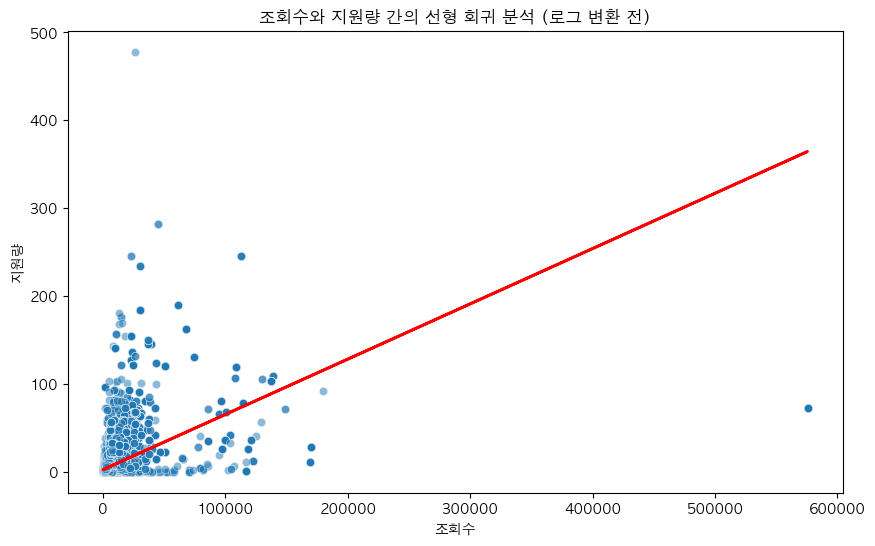

회귀 계수: 0.00063
절편: 2.32


In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

# 1. 데이터 준비
X = merged_df[['view_count']].values
y = merged_df['application_count'].values

# 2. 선형 회귀 모델 생성
model = LinearRegression()
model.fit(X, y)

# 3. 회귀선 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='view_count', y='application_count', alpha=0.5)
plt.plot(X, model.predict(X), color='red', linewidth=2)  # 회귀선 추가
plt.title('조회수와 지원량 간의 선형 회귀 분석 (로그 변환 전)')
plt.xlabel('조회수')
plt.ylabel('지원량')
plt.show()

# 4. 모델 계수 확인
print(f"회귀 계수: {model.coef_[0]:.5f}")
print(f"절편: {model.intercept_:.2f}")


In [ ]:
# 결정계수(R²) 확인
r_squared = model.score(X, y)
print(f"결정계수 (R²): {r_squared:.4f}")


결정계수 (R²): 0.2236


---
로그


/Users/soyeon/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


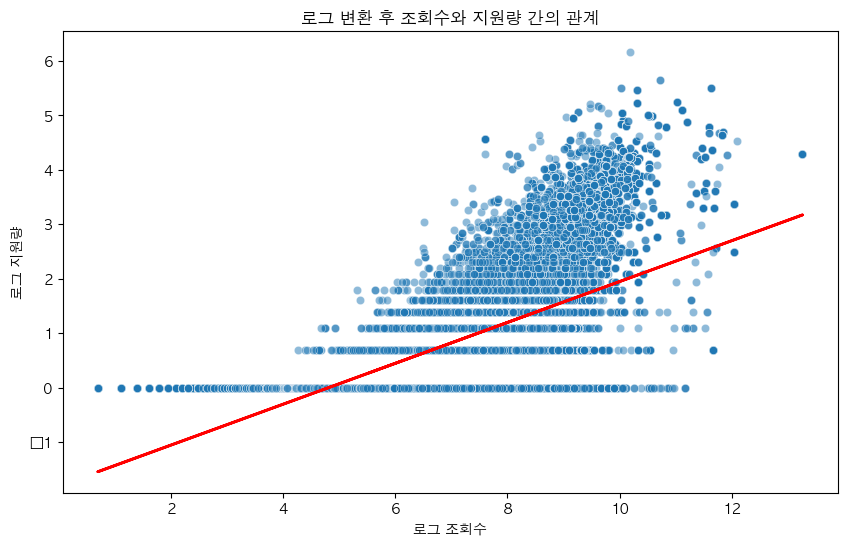

로그 변환 후 결정계수 (R²): 0.4410


In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 로그 변환 적용
merged_df['log_view_count'] = np.log1p(merged_df['view_count'])  # log(1 + x)
merged_df['log_application_count'] = np.log1p(merged_df['application_count'])

# 2. 로그 변환 후 선형 회귀 모델 생성
X_log = merged_df[['log_view_count']].values
y_log = merged_df['log_application_count'].values

model_log = LinearRegression()
model_log.fit(X_log, y_log)

# 3. 회귀선 시각화
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='log_view_count', y='log_application_count', alpha=0.5)
plt.plot(X_log, model_log.predict(X_log), color='red', linewidth=2)  # 회귀선 추가
plt.title('로그 변환 후 조회수와 지원량 간의 관계')
plt.xlabel('로그 조회수')
plt.ylabel('로그 지원량')
plt.show()

# 4. 결정계수(R²) 확인
r_squared_log = model_log.score(X_log, y_log)
print(f"로그 변환 후 결정계수 (R²): {r_squared_log:.4f}")


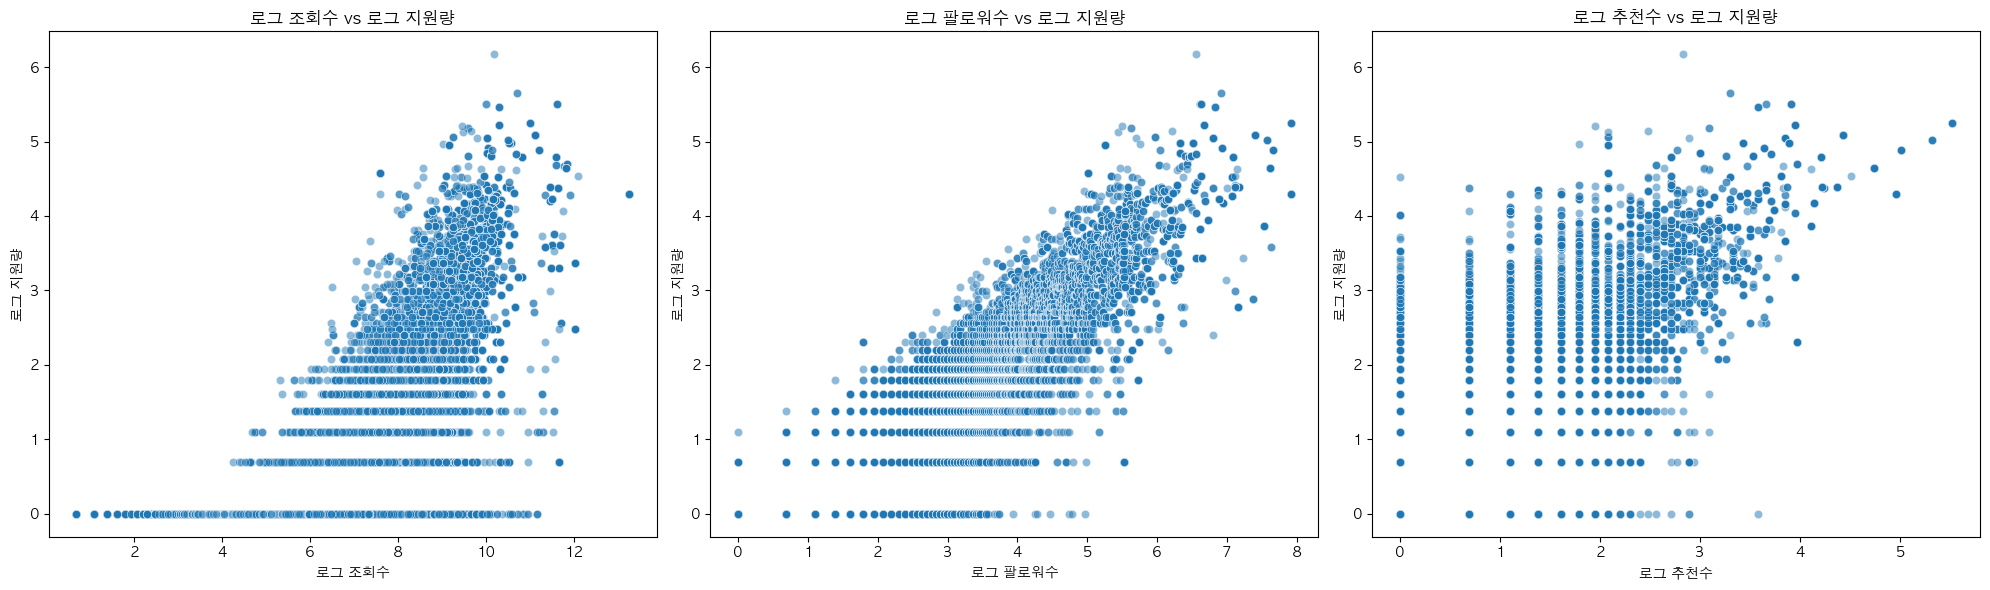

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 로그 변환 (log(1 + x) 사용)
merged_df['log_view_count'] = np.log1p(merged_df['view_count'])
merged_df['log_follow_count'] = np.log1p(merged_df['follow_count'])
merged_df['log_reference_count'] = np.log1p(merged_df['reference_count'])
merged_df['log_application_count'] = np.log1p(merged_df['application_count'])

# 2. 산점도 그래프 시각화 (로그 변환 후)
plt.figure(figsize=(20, 6))

# 조회수 vs 지원량
plt.subplot(1, 3, 1)
sns.scatterplot(data=merged_df, x='log_view_count', y='log_application_count', alpha=0.5)
plt.title('로그 조회수 vs 로그 지원량')
plt.xlabel('로그 조회수')
plt.ylabel('로그 지원량')

# 팔로워수 vs 지원량
plt.subplot(1, 3, 2)
sns.scatterplot(data=merged_df, x='log_follow_count', y='log_application_count', alpha=0.5)
plt.title('로그 팔로워수 vs 로그 지원량')
plt.xlabel('로그 팔로워수')
plt.ylabel('로그 지원량')

# 추천수 vs 지원량
plt.subplot(1, 3, 3)
sns.scatterplot(data=merged_df, x='log_reference_count', y='log_application_count', alpha=0.5)
plt.title('로그 추천수 vs 로그 지원량')
plt.xlabel('로그 추천수')
plt.ylabel('로그 지원량')

# 그래프 출력
plt.tight_layout()
plt.show()


# 📍 북마크 분석

## 북마크 퍼널 분석 및 A/B테스트

In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [ ]:
log_data = pd.read_csv('Cleaned_Logdata-001.csv')

In [ ]:
filtered_log_df = log_data.dropna()

In [ ]:
# 'bookmark'가 포함된 URL 목록 확인
bookmark_urls = filtered_log_df[filtered_log_df['URL'].str.contains('bookmark')]['URL'].unique()

# 결과 출력
print("북마크 관련 URL:")
for url in bookmark_urls:
    print(url)

비율 및 결과

#### api/companies/id/bookmark 전환율 분석
- **기존 북마크 전환율:** 1.94%
- **개선 후 북마크 전환율:** 2.27%
- **개선 비율:** 1.17 (17% 개선)

- **기존 북마크 전환 수:** 16,419
- **개선된 북마크 전환 수:** 19,212
- **기존 대비 증가한 북마크 수:** 2,793

#### api/jobs/id/bookmark 전환율 분석
- **기존 북마크 전환율:** 2.98%
- **개선 후 북마크 전환율:** 3.19%
- **개선 비율:** 1.07 (7.05% 개선)

- **기존 북마크 전환 수:** 89,280
- **개선된 북마크 전환 수:** 95,572
- **기존 대비 증가한 북마크 수:** 6,292

#### jobs/id/bookmarks 전환율 분석
- **기존 북마크 전환율:** 0.19%
- **개선 후 북마크 전환율:** 0.23%
- **개선 비율:** 1.21 (21% 개선)

- **기존 북마크 전환 수:** 11,075
- **개선된 북마크 전환 수:** 13,407
- **기존 대비 증가한 북마크 수:** 2,332

---

### **결론**
1. 회사 페이지 북마크 api/companies/id/bookmark 전환율이 **1.94%에서 2.27%로 개선**되었을 때, **일주일 동안 약 2,793건의 추가 북마크**를 기대할 수 있습니다.
2. 공고 상세 페이지 api/jobs/id/bookmark 북마크 전환율이 **2.98%에서 3.19%로 개선**되었을 때, **약 6,292건의 추가 북마크**를 기대할 수 있습니다.
3. jobs/id/bookmarks 전환율이 **0.19%에서 0.23%로 개선**되었을 때, **약 2,332건의 추가 북마크**를 기대할 수 있습니다.



# 📌 북마크 분석

In [ ]:
import pandas as pd
import numpy as np

### Q1 분석 계획: 북마크 후 실제 지원까지 소요되는 평균 시간 분석

1. 데이터 준비
- 북마크 데이터:
    - user_uuid, job_uuid, company_uuid, timestamp (북마크한 시점) 포함.
- 지원 데이터:
     -user_uuid, job_uuid, company_uuid, cdate (지원 날짜) 포함.
- 두 데이터셋을 user_uuid와 job_uuid를 기준으로 조인하여, 북마크 시점(timestamp)과 지원 시점(cdate)을 연결.

2. 소요 시간 계산
- 소요 시간 = 지원 시점(cdate) - 북마크 시점(timestamp)
    - 날짜 데이터를 datetime 형식으로 변환한 후 차이를 계산.

3. 평균 소요 시간 산출
- 모든 데이터에서 소요 시간을 계산한 후, 평균 값을 구함.
- 소요 시간 분포를 확인하여 중앙값도 함께 계산(왜곡된 값이 있는 경우 대비).

#### 1-1. 데이터 로드

In [ ]:
bookmark_data = pd.read_csv('../data/Cleaned_Jobbookmark.csv')  # 북마크 데이터
application_data = pd.read_csv('../data/Cleaned_Application.csv')  # 지원 데이터
job_data = pd.read_csv('../data/Cleaned_Job.csv')  # 지원 데이터

#### 1-2. 필요한 열만 필터링

In [ ]:
bookmark_data = bookmark_data[['user_uuid', 'job_uuid', 'cdate']]  # 북마크 시점
application_data = application_data[['user_uuid', 'job_uuid', 'cdate','application_uuid']]  # 지원 시점

#### 1-3. 날짜 데이터를 datetime 형식으로 변환

In [ ]:
bookmark_data['cdate'] = pd.to_datetime(bookmark_data['cdate'], format='mixed', errors='coerce')
application_data['cdate'] = pd.to_datetime(application_data['cdate'], format='mixed', errors='coerce')
job_data['cdate'] = pd.to_datetime(application_data['cdate'], format='mixed', errors='coerce')


# 변환되지 않은 값 확인
print(bookmark_data[bookmark_data['cdate'].isna()])
print(application_data[application_data['cdate'].isna()])

Empty DataFrame
Columns: [user_uuid, job_uuid, cdate]
Index: []
Empty DataFrame
Columns: [user_uuid, job_uuid, cdate, application_uuid]
Index: []


#### 1-4. 북마크 데이터와 지원 데이터를 user_uuid와 job_uuid를 기준으로 조인


In [ ]:
merged_data = pd.merge(bookmark_data, application_data, on=['user_uuid', 'job_uuid'], how='inner')
merged_data

,user_uuid,job_uuid,cdate_x,cdate_y,application_uuid
0,06d05db7-3c5f-4616-896f-286414ea3e6f,dd3dc97b-e00e-4513-8ccc-d9e49db35418,2020-04-14 15:11:33,2020-04-20 08:33:56.343596,5c4b72f2-5bf3-4811-a241-efe70b9e73dc
1,06d05db7-3c5f-4616-896f-286414ea3e6f,a400986d-3115-40b6-ac76-d8ba1e5910be,2019-06-14 01:16:19,2019-07-11 17:49:09.661994,8fab6402-24bd-435c-85d0-e22df70ae72a
2,0eec3780-6ee8-4ec6-9802-52c0e2a4f47d,8687efcc-01d7-4ee1-afbc-5672884a64e8,2019-12-03 06:15:29,2019-12-03 07:10:15.810378,94ba39be-74f1-448a-a454-f95037a93ef4
3,0eec3780-6ee8-4ec6-9802-52c0e2a4f47d,36b750e1-996e-41e1-bd21-c36401461b56,2019-03-11 07:52:09,2019-03-12 06:12:08.487719,c46192c5-6f97-475e-b9b2-f1518e5d6b44
4,0eec3780-6ee8-4ec6-9802-52c0e2a4f47d,db83f400-50b6-4cf1-8e13-5ba316b72891,2017-04-14 14:20:11,2017-04-25 17:13:49.000000,16b3c326-7629-4742-84c2-8145a14a1b10
...,...,...,...,...,...
33641,bfc30a6a-c2cd-487d-82a2-6a3feee6b646,e55a8921-4bce-4462-9c26-b4f54e632315,2021-04-21 09:35:38,2021-04-21 13:38:45.320025,283b865f-4942-4be9-ba5f-4756a1a8ca17
33642,d99d561b-9371-4aa5-bc89-95cd6908213d,ce522326-9a3a-4f8c-afad-7517837b6742,2018-08-03 02:46:47,2018-08-03 02:46:35.109455,fcef28a9-ca68-4b78-a5a1-1c8717d37741
33643,441ffb52-0446-40cc-8f39-b7b249b59773,17cacd98-8729-4710-bda8-27c56bf84edf,2020-01-28 14:16:10,2020-03-11 11:18:05.914167,6d805249-653e-444f-8a19-26d2b4b1ad47
33644,2ca27d55-97fc-4fab-93fc-69a1bee75706,17cacd98-8729-4710-bda8-27c56bf84edf,2020-05-26 09:04:40,2020-05-26 12:54:32.012198,cbe59875-e9b6-4d45-9a47-cdd04150e721


#### 1-5. 북마크 후 지원까지 소요 시간 계산

In [ ]:
merged_data['time_to_apply'] = (merged_data['cdate_y'] - merged_data['cdate_x']).dt.total_seconds() / 3600  # 시간 단위로 변환
bookmark_times = merged_data['time_to_apply']
bookmark_times

0         137.373151
1         664.547406
2           0.913003
3          22.333191
4         266.893889
            ...     
33641       4.052033
33642      -0.003303
33643    1029.032198
33644       3.831114
33645       0.284408
Name: time_to_apply, Length: 33646, dtype: float64

#### 1-6. 평균 소요 시간 계산

In [ ]:
average_time = merged_data['time_to_apply'].mean()  # 평균 소요 시간
median_time = merged_data['time_to_apply'].median()  # 중앙값 소요 시간

#### 1-7. 결과 출력

In [ ]:
print(f"북마크 후 실제 지원까지 평균 소요 시간: {average_time:.2f} 시간")
print(f"북마크 후 실제 지원까지 중앙값 소요 시간: {median_time:.2f} 시간")

북마크 후 실제 지원까지 평균 소요 시간: 139.41 시간
북마크 후 실제 지원까지 중앙값 소요 시간: 24.50 시간


#### 1-8. 소요 시간 분포 시각화


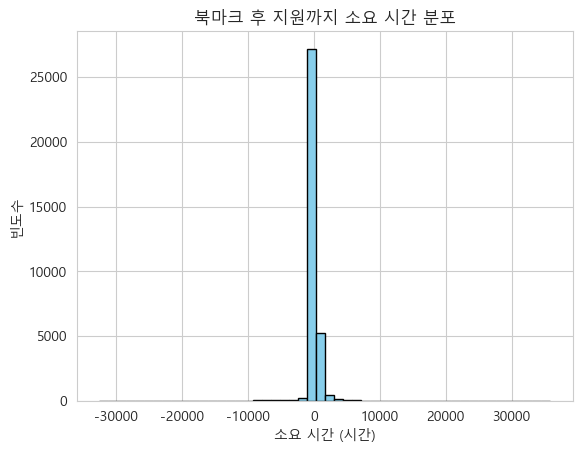

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.hist(merged_data['time_to_apply'], bins=50, color='skyblue', edgecolor='black')
plt.title('북마크 후 지원까지 소요 시간 분포')
plt.xlabel('소요 시간 (시간)')
plt.ylabel('빈도수')
plt.show()

#### 2-1. 북마크 없이 지원한 사용자 데이터 추출


In [ ]:
# 북마크 데이터에 포함된 job_uuid를 추출
bookmarked_jobs = bookmark_data['job_uuid'].unique()

# Application 데이터에서 북마크되지 않은 지원 기록 필터링
direct_applications = application_data[~application_data['job_uuid'].isin(bookmarked_jobs)]

print("북마크 없이 직접 지원한 사용자 데이터 개수:", len(direct_applications))

북마크 없이 직접 지원한 사용자 데이터 개수: 30502


#### 2-2. 북마크 후 지원 데이터 추출

- 북마크 데이터와 지원 데이터를 병합
- 북마크 후 지원한 데이터 필터링

In [ ]:
# 북마크 데이터와 지원 데이터를 병합
bookmark_application_data = pd.merge(
    bookmark_data,
    application_data,
    on=['user_uuid', 'job_uuid'],
    suffixes=('_bookmark', '_application')
)

# 북마크 후 지원한 데이터 필터링
bookmark_application_data = bookmark_application_data[
    bookmark_application_data['cdate_application'] > bookmark_application_data['cdate_bookmark']
]

print("북마크 후 지원한 사용자 데이터 개수:", len(bookmark_application_data))

북마크 후 지원한 사용자 데이터 개수: 29650


#### 북마크를 사용/ 미사용 비율은 약 50:50임을 알 수 있습니다.

#### 2-3. 지원 소요 시간 계산

- 북마크 후 지원 소요 시간 계산
- 직접 지원한 사용자는 job_posting_date와 지원 날짜 차이 계산

In [ ]:
# 북마크 후 지원 소요 시간 계산
bookmark_application_data['time_to_apply'] = (
    bookmark_application_data['cdate_application'] - bookmark_application_data['cdate_bookmark']
).dt.total_seconds() / 3600

# 직접 지원한 사용자는 job_posting_date와 지원 날짜 차이 계산
job_data = job_data.rename(columns={'cdate': 'job_posting_date'})
direct_applications = pd.merge(
    direct_applications,
    job_data[['job_uuid', 'job_posting_date']],
    on='job_uuid',
    how='left'
)
direct_applications['time_to_apply'] = (
    direct_applications['cdate'] - direct_applications['job_posting_date']
).dt.total_seconds() / 3600

In [ ]:
no_bookmark_times = direct_applications['time_to_apply']
no_bookmark_times

0        -2081.231291
1                 NaN
2                 NaN
3                 NaN
4        14654.520247
             ...     
30497    15235.732250
30498   -25085.169398
30499   -26004.371283
30500             NaN
30501   -12147.687522
Name: time_to_apply, Length: 30502, dtype: float64

#### 2-4. 평균 및 중앙값 비교


In [ ]:
# 북마크 후 지원 소요 시간
bookmark_avg_time = bookmark_application_data['time_to_apply'].mean()
bookmark_median_time = bookmark_application_data['time_to_apply'].median()

# 직접 지원 소요 시간
direct_avg_time = direct_applications['time_to_apply'].mean()
direct_median_time = direct_applications['time_to_apply'].median()

print("북마크 후 지원 평균 소요 시간:", round(abs(bookmark_avg_time), 2), "시간")
print("북마크 후 지원 중앙값 소요 시간:", round(abs(bookmark_median_time), 2), "시간")
print("직접 지원 평균 소요 시간:", round(abs(direct_avg_time), 2), "시간")
print("직접 지원 중앙값 소요 시간:", round(abs(direct_median_time), 2), "시간")

북마크 후 지원 평균 소요 시간: 243.67 시간
북마크 후 지원 중앙값 소요 시간: 45.52 시간
직접 지원 평균 소요 시간: 351.51 시간
직접 지원 중앙값 소요 시간: 258.67 시간


#### 2-5. 시각화

소요 시간 분포를 시각화하여 두 그룹 간 차이를 직관적으로 비교


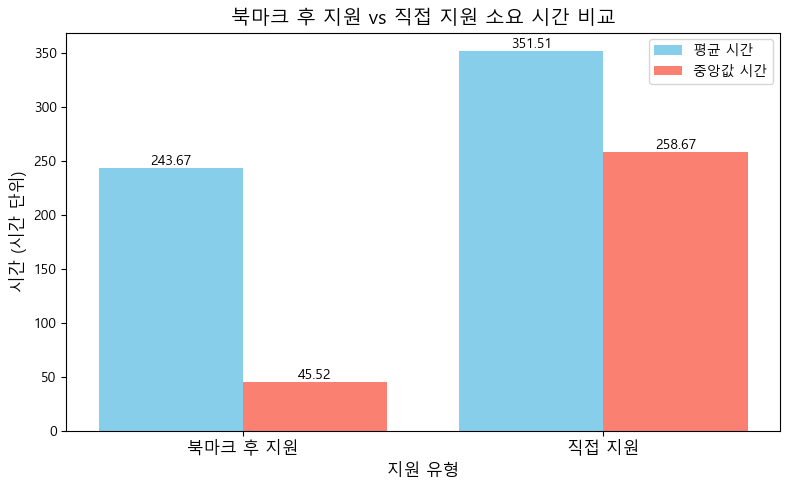

In [ ]:
import matplotlib.pyplot as plt

categories = ['북마크 후 지원', '직접 지원']
average_times = [abs(bookmark_avg_time), abs(direct_avg_time)]
median_times = [abs(bookmark_median_time), abs(direct_median_time)]

x = np.arange(len(categories))
width = 0.4

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, average_times, width, label='평균 시간', color='skyblue')
rects2 = ax.bar(x + width/2, median_times, width, label='중앙값 시간', color='salmon')

ax.set_xlabel('지원 유형', fontsize=12)
ax.set_ylabel('시간 (시간 단위)', fontsize=12)
ax.set_title('북마크 후 지원 vs 직접 지원 소요 시간 비교', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=12)
ax.legend()

def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width()/2.,
            height,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=10
        )

add_labels(rects1)
add_labels(rects2)

plt.tight_layout()
plt.show()

## 인사이트 도출

북마크 후 지원 평균 소요 시간: 243.67 시간

북마크 후 지원 중앙값 소요 시간: 45.52 시간

직접 지원 평균 소요 시간: 351.51 시간

직접 지원 중앙값 소요 시간: 258.67 시간

#### 위 결과로 '북마크' 기능은 구직 활동을 촉진시켜주는 요인이라고 해석할수 있습니다.

북마크 없이 직접 지원한 사용자 데이터 개수: 30502

북마크 후 지원한 사용자 데이터 개수: 29650

#### 하지만 북마크 사용 비율이 약 50:50으로 활발히 사용되고 있다고 보기 어려운 상황임을 알 수 있습니다.

### Q2. 북마크 후 공고 페이지를 다시 방문한 사용자와 그렇지 않은 사용자 간 전환율 차이가 있는가?

#### 목표: 북마크 후 재방문 여부가 전환율(지원율)에 영향을 미치는지 확인.
접근 방법:
    
    1. Log 데이터를 활용하여 재방문 사용자 식별:
        - Jobbookmark.cdate 이후 북마크한 공고 URL을 방문한 사용자 그룹(재방문)과 방문하지 않은 사용자 그룹(비재방문)으로 나누기.
    
    2. 두 그룹의 전환율 계산:
        - 전환율 = (지원한 사용자 수) / (그룹 내 총 사용자 수).

    3. 통계적 검정:
        - 카이제곱 검정 또는 t-검정을 사용해 그룹 간 전환율 차이가 통계적으로 유의한지 확인.

In [ ]:
log_data = pd.read_csv('../data/Cleaned_Logdata-001.csv')
log_data.drop('Unnamed: 0', axis=1, inplace=True)
log_data.drop('Unnamed: 0.1', axis=1, inplace=True)
log_data

,user_uuid,URL,timestamp,date,response_code,method
0,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/search/language?name=한국어&_=1655915651225,2022-06-22 16:42:48.247454 UTC,2022-06-23,200,GET
1,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/signup/form,2022-06-22 16:19:07.770741 UTC,2022-06-23,200,POST
2,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/users/id/template,2022-06-22 16:41:54.449837 UTC,2022-06-23,200,POST
3,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/users/id/template,2022-06-23 02:53:47.040932 UTC,2022-06-23,200,POST
4,8a7e70cd-1630-4a8a-8303-0706af3a7908,api/users/id/phone/verify/template?_=165591488...,2022-06-22 16:21:58.154299 UTC,2022-06-23,200,GET
...,...,...,...,...,...,...
16213710,167cdb14-d145-4679-b878-66a9a2d32ee9,@user_id,2023-11-14 12:12:26.780872 UTC,2023-11-14,200,GET
16213711,167cdb14-d145-4679-b878-66a9a2d32ee9,@user_id,2023-11-14 12:11:38.859562 UTC,2023-11-14,200,GET
16213712,f5649d90-3016-4747-9924-a05d74ee895e,api/users/id/template,2023-11-14 13:16:19.471324 UTC,2023-11-14,200,POST
16213713,f5649d90-3016-4747-9924-a05d74ee895e,verify_phone?next_url=/%40kkwangpe,2023-11-14 13:16:11.530244 UTC,2023-11-14,200,GET


#### 1. 북마크 데이터를 재방문 여부와 결합
- 북마크 데이터를 준비 (Jobbookmark와 Log 데이터를 병합)


In [ ]:
merged_data = pd.merge(
    bookmark_data,  # 북마크 데이터
    log_data,           # 로그 데이터
    how="inner",        # 공통된 user_uuid만 포함
    on="user_uuid"      # 병합 기준 열
)

In [ ]:
merged_data

,user_uuid,job_uuid,cdate,URL,timestamp,date,response_code,method
0,06d05db7-3c5f-4616-896f-286414ea3e6f,e9d423cb-2b66-4c9a-83a2-4f808bb9c8db,2018-08-01 13:00:37,api/jobs/job_title?keywords=가구디자인&page=&q=,2022-07-01 01:38:30.415337 UTC,2022-07-01,200,GET
1,06d05db7-3c5f-4616-896f-286414ea3e6f,e9d423cb-2b66-4c9a-83a2-4f808bb9c8db,2018-08-01 13:00:37,@user_id/following,2022-05-16 23:42:22.112631 UTC,2022-05-17,200,GET
2,06d05db7-3c5f-4616-896f-286414ea3e6f,e9d423cb-2b66-4c9a-83a2-4f808bb9c8db,2018-08-01 13:00:37,api/users/id/template,2022-05-16 23:41:26.707027 UTC,2022-05-17,200,POST
3,06d05db7-3c5f-4616-896f-286414ea3e6f,e9d423cb-2b66-4c9a-83a2-4f808bb9c8db,2018-08-01 13:00:37,api/companies/id/view,2022-02-12 12:37:50.059679 UTC,2022-02-12,200,POST
4,06d05db7-3c5f-4616-896f-286414ea3e6f,e9d423cb-2b66-4c9a-83a2-4f808bb9c8db,2018-08-01 13:00:37,api/companies/id/view,2022-01-25 01:19:40.107622 UTC,2022-01-25,200,POST
...,...,...,...,...,...,...,...,...
302421777,29c91aed-1892-409a-804b-2b56144f0616,a0ec9ae9-449c-47d1-8f04-7ead337c8597,2020-02-26 15:18:14,@user_id,2023-11-03 07:33:57.170604 UTC,2023-11-03,200,GET
302421778,29c91aed-1892-409a-804b-2b56144f0616,a0ec9ae9-449c-47d1-8f04-7ead337c8597,2020-02-26 15:18:14,companies/company_id,2023-11-03 07:33:52.063854 UTC,2023-11-03,200,GET
302421779,29c91aed-1892-409a-804b-2b56144f0616,a0ec9ae9-449c-47d1-8f04-7ead337c8597,2020-02-26 15:18:14,companies/company_id/jobs,2023-11-03 07:33:43.812369 UTC,2023-11-03,200,GET
302421780,29c91aed-1892-409a-804b-2b56144f0616,a0ec9ae9-449c-47d1-8f04-7ead337c8597,2020-02-26 15:18:14,api/companies/id/form,2023-11-03 07:33:05.917116 UTC,2023-11-03,200,POST


In [ ]:
# timestamp 열을 datetime 형식으로 변환 (UTC 시간대가 있는 경우)
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'], errors='coerce')

# 시간대 정보 제거
merged_data['timestamp'] = merged_data['timestamp'].dt.tz_localize(None)

# 변환된 결과 확인
print(merged_data['timestamp'].head())

0   2022-07-01 01:38:30.415337
1   2022-05-16 23:42:22.112631
2   2022-05-16 23:41:26.707027
3   2022-02-12 12:37:50.059679
4   2022-01-25 01:19:40.107622
Name: timestamp, dtype: datetime64[ns]


#### 2. 북마크 생성일 이후 공고 URL 재방문 여부 확인
북마크 생성일보다 이후에 공고 URL을 방문한 기록 여부를 확인

작업 내용:
- timestamp(로그 데이터의 방문 시간)과 cdate(북마크 생성일)를 datetime 형식으로 변환.
- 공고 URL 방문 시간(timestamp)이 북마크 생성일(cdate) 이후인지 확인하여 revisit(재방문 여부) 열 생성.
    - True: 북마크 생성일 이후 재방문한 경우.
    - False: 재방문하지 않은 경우.

목적:
- 북마크 후 공고 페이지를 실제로 다시 방문했는지 여부를 식별.

In [ ]:
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp'])
merged_data['cdate'] = pd.to_datetime(merged_data['cdate'])
merged_data['revisit'] = merged_data['timestamp'] > merged_data['cdate']

재방문 여부 데이터 만들기

작업 내용:
- 동일한 사용자와 공고 ID 조합에 대해, revisit 값이 True인지 확인.
- max() 함수를 사용하여 revisit 값 중 하나라도 True라면 최종적으로 재방문한 것으로 간주.

목적:
- 사용자별 재방문 여부를 요약하여 중복 제거 및 간결한 데이터 생성.

In [ ]:
bookmark_logs_grouped = merged_data.groupby(['user_uuid', 'job_uuid']).agg({'revisit': 'max'}).reset_index()

#### 3. 재방문 여부와 지원 데이터 결합
북마크 데이터와 지원 데이터를 병합하여 지원 여부를 확인

작업 내용:
- bookmark_logs_grouped와 지원 데이터(application_data)를 사용자 ID(user_uuid)와 공고 ID(job_uuid) 기준으로 병합.
- 지원 여부를 나타내는 열 applied를 생성.
    - True: application_uuid 값이 존재(즉, 해당 공고에 지원).
    - False: application_uuid 값이 결측치(지원하지 않음).

목적:
- 사용자가 북마크한 공고에 실제로 지원했는지 여부를 확인.

In [ ]:
bookmark_applications = pd.merge(
    bookmark_logs_grouped,
    application_data,
    how="left",
    on=["user_uuid", "job_uuid"]
)

지원 여부 추가


In [ ]:
bookmark_applications['applied'] = ~bookmark_applications['application_uuid'].isna()

#### 4. 사용자 그룹 나누기
재방문 여부에 따른 두 그룹

작업 내용:
- 재방문 여부(revisit)를 기준으로 두 그룹으로 나눔.
    - revisit_group: 재방문한 사용자들.
    - no_revisit_group: 재방문하지 않은 사용자들.

목적:
- 두 그룹의 전환율(지원율)을 비교하기 위해 그룹을 정의.

In [ ]:
revisit_group = bookmark_applications[bookmark_applications['revisit'] == True]
no_revisit_group = bookmark_applications[bookmark_applications['revisit'] == False]

각 그룹별 전환율 계산

작업 내용:
- 전환율 계산: applied 열의 평균값을 계산하고 100을 곱해 퍼센트로 변환.
    - 전환율 공식: (지원 사용자 수) / (그룹 내 총 사용자 수) * 100.

목적:
- 재방문 여부에 따른 전환율 차이를 확인.

In [ ]:
revisit_conversion_rate = revisit_group['applied'].mean() * 100
no_revisit_conversion_rate = no_revisit_group['applied'].mean() * 100

print("재방문 그룹 전환율:", round(revisit_conversion_rate, 2), "%")
print("비재방문 그룹 전환율:", round(no_revisit_conversion_rate, 2), "%")

재방문 그룹 전환율: 13.65 %
비재방문 그룹 전환율: 1.48 %


#### 5. 통계 검정 (카이제곱 검정)

작업 내용:
- 그룹별 지원 여부를 기준으로 교차표(Contingency Table)를 생성.
- 카이제곱 검정을 통해 두 그룹 간 전환율 차이의 통계적 유의성을 확인.
    - chi2: 카이제곱 통계량.
    - p: p-value.
    - dof: 자유도.
    - expected: 기대빈도.

목적:
- 두 그룹의 전환율 차이가 단순한 우연이 아닌 통계적으로 유의미한 차이인지 확인.

In [ ]:
from scipy.stats import chi2_contingency

contingency_table = [
    [revisit_group['applied'].sum(), len(revisit_group) - revisit_group['applied'].sum()],
    [no_revisit_group['applied'].sum(), len(no_revisit_group) - no_revisit_group['applied'].sum()]
]

chi2, p, dof, expected = chi2_contingency(contingency_table)

print("카이제곱 통계량:", chi2)
print("p-value:", p)

if p < 0.05:
    print("결론: 재방문 여부에 따른 전환율 차이는 통계적으로 유의하다.")
else:
    print("결론: 재방문 여부에 따른 전환율 차이는 통계적으로 유의하지 않다.")

카이제곱 통계량: 411.8845083899923
p-value: 1.4253438990698388e-91
결론: 재방문 여부에 따른 전환율 차이는 통계적으로 유의하다.


#### 6. 시각화

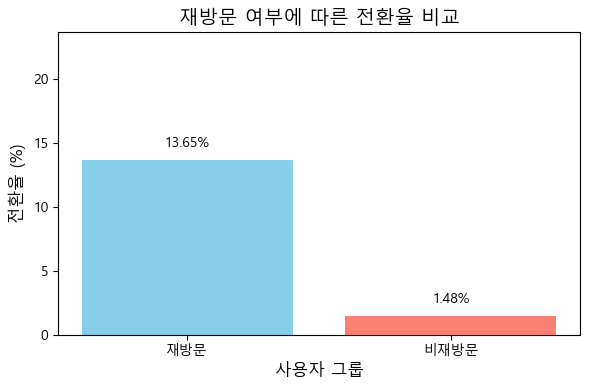

In [ ]:
import matplotlib.pyplot as plt

groups = ['재방문', '비재방문']
conversion_rates = [revisit_conversion_rate, no_revisit_conversion_rate]

plt.figure(figsize=(6, 4))
plt.bar(groups, conversion_rates, color=['skyblue', 'salmon'])
plt.xlabel('사용자 그룹', fontsize=12)
plt.ylabel('전환율 (%)', fontsize=12)
plt.title('재방문 여부에 따른 전환율 비교', fontsize=14)
plt.ylim(0, max(conversion_rates) + 10)

for i, rate in enumerate(conversion_rates):
    plt.text(i, rate + 1, f'{rate:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 인사이트 도출

#### 1. 재방문 그룹과 비재방문 그룹 전환율

재방문 그룹 전환율: 13.65%
    
    → 북마크를 하고 재방문한 사용자들의 전환율(지원한 비율)이 매우 높습니다.

비재방문 그룹 전환율: 1.48%
    
    → 북마크를 했지만 해당 공고로 다시 돌아오지 않았으며, 바로 지원했거나 지원하지 않았을 가능성이 큰 그룹.(북마크의 기능을 온전히 사용하지 않은 그룹)

해석:
- 재방문 그룹이 비재방문 그룹에 비해 전환율이 약 9배 이상 높은 것으로 보입니다.
- 북마크를 하고 재방문하는 행동이 실제로 지원 활동으로 이어질 가능성을 크게 높이는 경향을 보입니다.

#### 2. 카이제곱 통계량: 411.884
- 카이제곱 통계량은 두 집단(재방문/비재방문) 간의 전환율 차이가 단순히 우연히 발생한 것인지 아닌지를 측정하는 지표입니다.
- 이 값이 클수록 두 그룹 간의 차이가 통계적으로 유의미할 가능성이 높습니다.

해석:
411.884라는 매우 큰 카이제곱 통계량은 두 그룹 간의 차이가 통계적으로 매우 유의미함을 시사합니다.

#### 3. p-value: 1.43e-91 (≈ 0)
- p-value는 귀무가설(북마크 여부가 전환율에 영향을 미치지 않는다)을 기각할지 여부를 결정하는 기준입니다.
- 일반적으로 p-value가 0.05보다 작으면 귀무가설을 기각하고, 두 변수 간의 관계가 유의미하다고 판단합니다.


해석:
p-value가 극도로 작은 값(≈ 0)이므로, 귀무가설을 강하게 기각할 수 있습니다. 즉, 북마크를 하고 재방문한 그룹과 그렇지 않은 그룹 간의 전환율 차이는 우연이 아니라 유의미한 차이입니다.

#### 4. 종합적 해석
- 북마크와 재방문 행동은 전환율(지원율)에 매우 강한 영향을 미치는 요인으로 보입니다.
- 실무적 의미:
    1. 북마크 기능을 적극적으로 홍보하거나 사용자들이 북마크를 쉽게 활용하도록 유도하는 UX/UI 개선이 필요합니다.
    2. 재방문을 유도하는 푸시 알림, 이메일 알림 같은 리마인더 기능을 강화하면 전환율이 증가할 가능성이 높습니다.
    3. 북마크와 재방문 행동의 특성을 더욱 세분화해(예: 직무별, 사용자군별) 맞춤형 개선 전략을 설계할 수 있습니다.

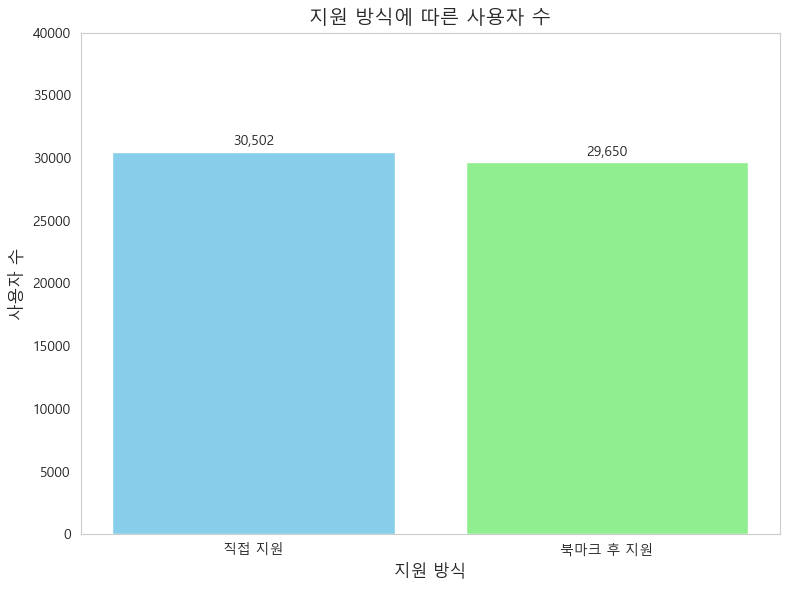

In [ ]:
import matplotlib.pyplot as plt

# 데이터
categories = ['직접 지원', '북마크 후 지원']
values = [30502, 29650]

# 막대그래프 생성
plt.figure(figsize=(8, 6))
plt.bar(categories, values, color=['skyblue', 'lightgreen'])
plt.title('지원 방식에 따른 사용자 수', fontsize=14)
plt.ylabel('사용자 수', fontsize=12)
plt.xlabel('지원 방식', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 40000)  # y축 최대값 설정
plt.grid(False)  # 격자줄 제거

# 막대에 값 표시
for i, value in enumerate(values):
    plt.text(i, value + 500, f'{value:,}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### 북마크 후 지원 소요시간 vs 직접 지원 소요시간 t-test

In [ ]:
bookmark_data = pd.read_csv('../data/Cleaned_Jobbookmark.csv')  # 북마크 데이터
application_data = pd.read_csv('../data/Cleaned_Application.csv')  # 지원 데이터
job_data = pd.read_csv('../data/Cleaned_Job.csv')  # 지원 데이터

In [ ]:
bookmark_times.dropna(inplace=True)
no_bookmark_times.dropna(inplace=True)

In [ ]:
import scipy.stats as stats

t_stat, p_value = stats.ttest_ind(bookmark_times, no_bookmark_times)

# 결과 출력
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value:.6f}")

# p-value가 0.05 이하라면 통계적으로 유의미한 차이가 있다고 할 수 있음
if p_value < 0.05:
    print("두 그룹 간 평균 차이는 유의미합니다.")
else:
    print("두 그룹 간 평균 차이는 유의미하지 않습니다.")

T-Statistic: 3.984374787133607
P-Value: 0.000068
두 그룹 간 평균 차이는 유의미합니다.
